# Tutorial 8.1 Thinking with Deep Learning: Week 8 Part 1
# Reinforcement Learning

__Instructor:__ James Evans

__Notebook Author:__ Bhargav Srinivasa Desikan

__Teaching Assistants & Course Organizers:__ Likun Cao & Partha Kadambi 


In this notebook we will begin to explore reinforcement learning. Let's start with using this [cheatsheet of RL terms](https://colab.research.google.com/drive/1eN33dPVtdPViiS1njTW_-r-IYCDTFU7N#scrollTo=NXMgDjEcZ47S) from this [PyTorch tutorial](https://pytorch.org/tutorials/intermediate/mario_rl_tutorial.html) to ground ourselves. Another powerful introduction, though it is a focus on Deep Reinforcement Learning: [OpenAI Spinning Up](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html).

A large part of this notebook will be using the workshops and tutorials from the O'Reilly book on Reinforcement Learning: https://rl-book.com/learn/

# Bandit Learning

We begin with perhaps the most basic RL application, and the one most familiar to the social sciences: bandit learning. A one-armed bandit is a euphemism for a slot machine: pulling the arm--taking a certain action--provides you with a certain probability of success. A multi-armed bandit represents an experiment between multiple actions (arms) that conditions different distributions of success, dynamically and "intelligently" allocating traffic to the arms that perform well, while allocating less to those that underperform. Ulimately, the winning "arm" or action (e.g., experimental condition, digitally served advertisement, algorithmic music recommendation) is identified and selected. The reason for the slot machine metaphor is that our opening assumption--a very conservative assumption--is that there will be no difference between the two slot-machine arms. Only once we see that one arm is yielding better payoffs consistently do we shift our energy to that option. 

https://github.com/tensorflow/agents/blob/master/docs/tutorials/bandits_tutorial.ipynb

## Bandit Algorithms

Bandit algorithms optimize single competing actions in the shortest amount of time. Imagine you are attempting to find out which advertisement provides the best click-through rate or which button generates the most sales. You could show two ads and count the number of clicks on each, over a one week period. But this is expensive: many people would see a sub-optimal ad. Instead, you can learn over time and progressively shift the shown ad towards the one performing better.

## The Testing Environment

Here we will leverage a bandit library to simulate the behaviour and provide the first algorithm that chooses an action. We do this to get you up and running quickly.

First we install the library and define the simulated behavior of the users.


In [1]:
!pip install banditsbook==0.1.1 > /dev/null

In [2]:
from arms.bernoulli import BernoulliArm

# Define two adverts, with a probability of clicking from the users
# This is a simulation. Imagine that these are real ads.
arm0 = BernoulliArm(0.05)
arm1 = BernoulliArm(0.4)
arms = [arm0, arm1]

This is an important definition, which glosses over a few important aspects. Primarily, these simulations are responsible for providing a reward to the advertiser whenever the simulated person clicks on an ad. Sometimes the reward is 0, when they don't click, other times it's a 1 when they do. Look:

In [3]:
[arm1.draw() for _ in range(5)]

[0.0, 0.0, 0.0, 0.0, 1.0]

## Running the Experiment With a Random Algorithm

Now we have the "environment" simulated (the users who click or don't click on our ad), we can run various algorithms to see how often the optimal action is presented to the user.

A good baseline is a random advertising agent, so let's try that first.

We need some supporting code, because we're not interested in raw decisions. We want to see how often ad 2 was chosen. To do this, we will repeat the experiment 1000 times, and measure the proportion of times ad 2 was chosen.

In [4]:
import pandas as pd
from algorithms.epsilon_greedy.standard import EpsilonGreedy
from testing_framework.tests import test_algorithm

epsilon = 1 # Choose a random action every time
num_sims = 1000 # Number of repetitions
horizon = 250 # Length of experiment

df = pd.DataFrame() # Buffer
algo1 = EpsilonGreedy(epsilon, [], []) # Algorithm
sim_nums, times, chosen_arms, rewards, cumulative_rewards = test_algorithm(
        algo1, arms, num_sims, horizon) # Running the environment/algorithm via the library
arrays = [[epsilon] * num_sims * horizon, sim_nums, times] # Constructing the output array for aggregation
index = pd.MultiIndex.from_arrays(
        arrays, names=('epsilon', 'simulation', 'time'))
df_chosen_arm = pd.DataFrame(chosen_arms, index=index)
df_chosen_arm = df_chosen_arm.groupby(level=[0, 2]).sum() / num_sims # Aggregating to result in the proportion of time
df = df.append(df_chosen_arm) # Append to buffer.

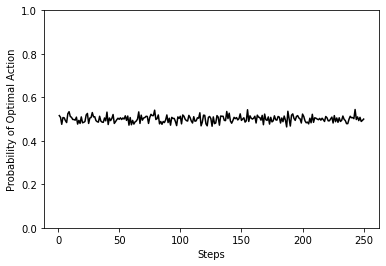

In [5]:
import matplotlib

df.loc[1].plot(legend=None,ylim=[0,1],ylabel="Probability of Optimal Action",xlabel="Steps",color="k");

As you can see, the optimal action is being selected half the time, on average. This is the expected result for a random agent with two actions.

## The $\epsilon$-Greedy Algorithm

Now let's try and repeat with several different values of $\epsilon$, the value that chooses the amount of time the algorithm chooses a random action. An $\epsilon$ of 0 would never choose a random action. The moment they sense that one of the advertisements is performing better than the other it will subsequently pick the same action over an over again, without ever exploring others (although its first action will be random).

In [6]:
df = pd.DataFrame()
for epsilon in [0, 0.1, 0.5, 1]:
    algo1 = EpsilonGreedy(epsilon, [], [])
    sim_nums, times, chosen_arms, rewards, cumulative_rewards = test_algorithm(
        algo1, arms, num_sims, horizon)

    arrays = [[epsilon] * num_sims * horizon, sim_nums, times]
    index = pd.MultiIndex.from_arrays(
        arrays, names=('epsilon', 'simulation', 'time'))
    df_chosen_arm = pd.DataFrame(chosen_arms, index=index)
    df_chosen_arm = df_chosen_arm.groupby(level=[0, 2]).sum() / num_sims
    df = df.append(df_chosen_arm)

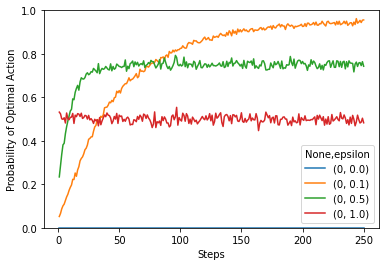

In [7]:
df.unstack(level=0).plot(ylim=[0,1],ylabel="Probability of Optimal Action",xlabel="Steps");

Now there are several plots with different values of $\epsilon$. You can see that when $\epsilon$ (the probability of exploration) is one, then the advertising agent never picks the optimal action. They explore continuously. An $\epsilon$ of .5 picks the optimal value half the time, exploring the other half. An $\epsilon$ of .1 picks the optimal value 10% of the time, exploring for 70%.

One thing you will notice is the speed of convergence. The more exploration there is, the longer it will take to reach an optimal value, but the higher the optimal will be.


## Comparing Simple Exploration Techniques: ε-Greedy, Annealing, and UCB

Following on the previous experiment with ε-Greedy methods, the next question is, can we explore more intelligently?

The answer is yes. Bandits generally use three forms of exploration. The first is standard ε-Greedy, which randomly chooses an action some proportion ($\epsilon$) of the time. The second uses a principle called simulated annealing, which begins randomly (e.g., with a "high temperature" as when annealing metal), exploring widely at first, but reducing exploration over time (e.g., "cooling down") to focus on the best performing action. Finally, we may follow an upper confidence bound (UCB) principle, which chooses an action depending on how often the action has been sampled. Rather than exploring randomly, like ε-Greedy throughout and simulated annealing at the beginning, UCB is rewarded for exploring only where it has not explored before and knows little about the nature of pay-off.

## The Testing Environment

We will reuse the environment from the previous ε-Greedy experiment. 

In [8]:
!pip install banditsbook==0.1.1 pandas==1.1.2 matplotlib==3.3.2 &2> /dev/null

     |████████████████████████████████| 10.5 MB 4.8 MB/s 
     |████████████████████████████████| 11.6 MB 19.1 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [9]:
from arms.bernoulli import BernoulliArm

# Define two adverts, with a probability of clicking from the users
# This is a simulation. Imagine that these are real ads.
arm0 = BernoulliArm(0.05)
arm1 = BernoulliArm(0.4)
arms = [arm0, arm1]

## Running the Experiment

The code below will compare the three algorithms on the simulated environment. 

In [10]:
from arms.bernoulli import BernoulliArm
from testing_framework.tests import test_algorithm
from algorithms.epsilon_greedy.standard import EpsilonGreedy
from algorithms.softmax.annealing import AnnealingSoftmax
from algorithms.ucb.ucb1 import UCB1
import pandas as pd
import random

random.seed(42)

num_sims = 1000 # Repetitions
horizon = 250 # Number of steps in experiment
n_arms = len(arms)

algo1 = AnnealingSoftmax([], []) # Annealing ε-Greedy
algo1.initialize(n_arms)
algo2 = EpsilonGreedy(0.05, [], []) # Standard ε-Greedy, exploring 5% of the time
algo3 = UCB1([], []) # UCB
algo3.initialize(n_arms)
algos = [("e_greedy", algo2), ("annealing_softmax", algo1), ("ucb", algo3)]

# A bit of code to loop over each algorithm and average the results
df = pd.DataFrame()
for algo in algos:
    sim_nums, times, chosen_arms, rewards, cumulative_rewards = test_algorithm(
        algo[1], arms, num_sims, horizon)
    arrays = [sim_nums, times]
    index = pd.MultiIndex.from_arrays(
        arrays, names=('simulation', 'time'))
    df_chosen_arm = pd.DataFrame(chosen_arms, index=index, columns=[algo[0]])
    df_probability_selected = df_chosen_arm.groupby(level=1).sum() / num_sims
    df = pd.concat([df, df_probability_selected], axis=1)

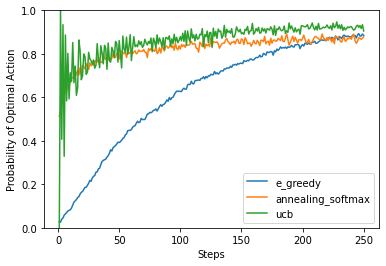

In [11]:
df.plot(ylim=[0,1],ylabel="Probability of Optimal Action",xlabel="Steps");

You can see that the ε-Greedy algorithm is taking a long time to converge to a similar level of performance. The reason being that it is still spending a large proportion of the time chossing random actions.

The annealing version rapidly reduces the amount of random exploration to speed this learning up. This is better, but you need to tune the hyper-parameters (initial exploration rate, final exploration rate and how fast to anneal) for your specific problem.

UCB attempts to quantify the number of times that action/state has been explored. If it has been explored a lot, and it is not the best action, then there's little point in exploring more. This is good because there are no hyper-parameters but you'll need to store a representation of visit counts; something that might not be possible for certain very large-scale problems, requiring massive memory outlays.

There is more to learn about Bandits (e.g., contextual bandits), but for us they were the gateway to discuss more complex reinforcement learning outcomes, introducing the idea of agent (the advertiser in our last example), environment (the internet browsers and advertisement consumers in that example), and reward (click-through rate, supplemented in UCB with a bonus for exploring unexplored states. With that background, we introduce the broader Reinforcement Learning formalism.

# Reinforcement Learning Dictionary



## Basic Concept - the Markov Decision Process (MDP)

Reinforcement learning is a framework in which a computational ***agent*** can be trained to perform intelligent action within an ***environment***. The agent can be a physical robot, a recommendation system, a gaming daemon, an automated investor or (social) scientist, and their environments can be digital or exist in the real world. The reinforcement learning framework lies atop the formalism of the Markov Decision Process. A Markov Decision Process (MDP) involves an ***environment*** that takes on *states* ($s$) and offers *rewards* ($r$) and an ***agent*** that takes actions that change the environment (and its states and rewards in the next period) as guided by a policy ($\pi(s,r)$).

![pic](https://drive.google.com/uc?id=1dPaV7kJ12lndPH9SxRgT-mX-7hVuDaUi)




### Action
$$
a \in {\rm I\!R}^{d_a}
$$
Under the MDP framework, an agent can act, either hungily and rationally to maximize its reward in the next step, randomly, disregarding its environmental state and reward, or some combination of the two. Action is how the agent responds to the environment. Action could be a real value or a vector (with $d_a$ values or dimensions). The set of all actions the agent can make is called the *action space*. 

### State
$$
s \in {\rm I\!R}^{d_s}
$$
State is what characterizes the current environment. It is experienced directly and lies outside the agent's control. 
Like action, state could be a real value or a vector (of dimension $d_s$). The set of all possible states in which the environment can reside is called the *state space*. 



### Reward
$$
r \in {\rm I\!R}
$$
Reward is the feedback from environment to agent. It is what drives the agent to learn and change its future action. Consider reward as training data in a supervised learning framework. Unlike action and state, reward is always a single, scalar value. 


## Basic MDP Relationship

$$
a_t \sim \pi(s_t)
$$

What does the agent's action depend on? The agent acts based on observation of the state of the environment. Reward changes how the agent acts in future, but not how the agent makes current action. 

The function $\pi$ is the agent's *action policy*. It characterizes how the agent reacts to environment to seek future reward. We use $\sim$ instead of $=$ here because the action policy returns a probability distribution. For example, under $\epsilon$-greedy policy, the agent chooses a random action $\epsilon$ percentage of the time. 

RL is framed as a dynamic process. We refer to each concept at a specific time step with subscript $t$. 

--------

$$
s_{t+1} \sim f(s_t, a_t)
$$
 
The next state the environment will enter is naturally constrained by its the current state $s_t$ (the Markov assumption). In addition, it depends on the agent's action $a_t$ in that environment. The environment could behave with certain randomness rather than deterministically, and so $f(s_t, a_t)$ is also modeled as a probability distribution. 

----

$$
r_{t+1} =  R(s_t, a_t)
$$


Reward captures how happy/unhappy the agent is with the change in environment + their own action. To capture such change, we need the previous state $s_t$, the previous action $a_t$, and the current state $s_{t+1}$. Because we can model the current state using $s_{t+1} \sim f(s_t, a_t)$, we say the reward is a function of $s_t$ and $s_{t+1}$. 


## Return



### Trajectory
$$
(s_0, a_0, s_1, a_1, ..., s_T)
$$

Trajectory is a sequence of states and actions that fully characterizes the entire RL process. A terminal state $s_T$ exists only for an episodic process; otherwise the trajectory goes on forever. Notice that reward is not part of the trajectory. Think about reward as an arbitrarily imposed signal to change how the agent chooses its action, but it does not contain any information about the trajectory itself. 



### Return
$$
R(\tau) = \sum_{t = 0}^T r_t \gamma^t
$$

Return is the accumulated reward over an entire trajectory, with a discount factor $\gamma$. Without $\gamma$, return is simply a sum of all rewards the agent collects. The discount factor $\gamma$ serves to emphasize the short- over long-term reward in future. At the same time, it's also computationally efficient dampen the return calculation so it does not require gazing into the infinite future.

### Value function
$$
V^{\pi}(s) = \mathbf{E}_{\tau \sim \pi}[R(\tau) | s_0 = s]
$$

We are often interested in the return $R(\tau)$ from a given starting state. We call this expected value the *value function*. As the *value function* concerns the entire trajectory starting from $s$, it is necessarily dependent on the *action policy*, which governs how the agent responds to environment states and thus the entire trajectory. We use $\tau \sim \pi$ in the expected value to indicate the trajectory is determined by the *action policy*. 



### Action value function
$$
Q^{\pi}(s, a) = \mathbf{E}_{\tau \sim \pi}[R(\tau) | s_0 = s, a_0 = a]
$$

Building atop the *value function*, the *action value function* models the expected return starting from a given state and the agent making a particular action. Given a starting state $s$, the *value function* models when the agent makes its first action based on the action policy $a \sim \pi(s)$, while *action value function* models when the first action is as given. 


![pic](https://drive.google.com/uc?id=1Dfijscr2WLJMrypF-ACD_ZwiXLrl8vsw)


Consider this state transition from $s$ to $s'$, where the agent can choose an action from $a_1, a_2, a_3$. The *Action value function* is conditioned on one chosen action. The *value function*, on the other hand, models the expected value of all possible *action value functions* so long as the action is sampled from agent's *action policy*. 

$$
V^{\pi}(s) = \mathbf{E}_{a \sim \pi(s)}[Q^{\pi}(s, a)]
$$


## Optimal Return

The agent's immediate reward, and their anticipated stream of future rewards or *return* is what stimulates the agent to learn. In other words, the agent tries to act such that their overall return is maximized. We are interested in the maximal return achievable from a given starting state, with a given action in the first time step. 




### Optimal value function
$$
V^*(s) = \max_{\pi} \mathbf{E}_{\tau \sim \pi}[R(\tau) | s_0 = s]
$$

*Optimal value function* is the *value function* when the best *action policy* is used. Here, the term *best* is defined as the one that gives the highest *value function*. We use $*$ to indicate such an optimal *action policy* in place of $\pi$. 




### Optimal action value function
$$
Q^*(s, a) = \max_{\pi} \mathbf{E}_{\tau \sim \pi}[R(\tau) | s_0 = s, a_0 = a]
$$

Similarly, *optimal action value function* is the *action value function* when the best *action policy* is used. Because the first action is explicitly given as $a$, the optimal action policy is only used starting from the second action. 

Note that unlike definitions for *value function* and *action value function*, these two optimal functions are independent of the actual action policy. They simply care about the optimal return achievable from a starting state (and action), regardless of the policy being used. In the Q-learning algorithm, Q stands for the *optimal* action value function. With an optimal Q function, we obtain our optimal action at a given state. 


## Optimal Action

$$
a^*(s) = argmax_a Q^*(s, a)
$$

If we have the optimal action value function $Q^*$ at state $s$,  then our optimal action $a^*$ is the action that yields the highest $Q^*$ value. Note that this optimal action is not "greedy": it doesn't simply try to maximize the reward from the next state, but optimizes the total return over the entire trajectory, taking into account all future steps. 

One could say that the above optimal action is one possible action policy for the agent. 

## Bellman Equation and Dynamic Programming

Named after Richard E. Bellman, a Bellman equation writes the "value" of a decision problem at a certain point in time in terms of payoff from initial choices and the "value" of the remaining decision problem that results from those initial choices, breaking a dynamic optimization problem into a sequence of simpler subproblems, as Bellman's “principle of optimality” prescribes.

The basic concepts of dynamic programming are prefigured in John von Neumann and Oskar Morgenstern's *Theory of Games and Economic Behavior* and Abraham Wald's sequential analysis, 'Bellman equation' usually refers to the dynamic programming equation associated with discrete-time optimization problems (e.g., where time occurs in steps), for which any multi-stage optimization problem can be solved analyzing the appropriate Bellman equation. 

![pic](https://drive.google.com/uc?id=1Dfijscr2WLJMrypF-ACD_ZwiXLrl8vsw)




### Bellman equation, value function
$$
V^{\pi}(s) = \mathbf{E}_{a \sim \pi(s), s' \sim f(s,a)}[r(s, a) + \gamma V^{\pi}(s')]
$$

$\gamma$ is the discounting factor, $\pi$ is our action policy, $f(s, a)$ models the environment and $s'$ is the next state. 


To calculate the expected return of current state $V^{\pi}(s)$, we see that it should be a sum of reward from the current step/state and expected return from the next state with discount factor $\gamma$. The reward from the current step depends on the action taken, modeled by $a \sim \pi(s)$, and expected return from next state is simply $V^{\pi}(s')$, where $s'$ represents the next state. To get $s'$, recall that our environment models the next state as $s' \sim f(s, a)$. 





### Bellman equation, action value function

$$
Q^{\pi}(s, a) = r(s, a) + \gamma \mathbf{E}_{a' \sim \pi(s'), s' \sim f(s,a)}[Q^{\pi}(s', a')]
$$

$a'$ is the next action sampled from action policy $\pi(s')$.  

Expected return of current state-action pair $Q^{\pi}(s, a)$ is similarly calculated as the sum of current reward $r(s, a)$ and value function from next state-action pair $Q^{\pi}(s', a')$. Since the action for the current step is given as $a$, we don't need to choose it based on policy $\pi$. However, in this case, as we are using both state and action from the next step, we will need to first model the next state, $s' \sim f(s,a)$, and then sample the next action as $a' \sim \pi(s')$. 

The Bellman equation characterizes the relationship between value function from current state and that from next state. By chaining value functions of connecting states, the Bellman equation enables us to model each state's expected return based on the next state's, eventually stopping at the terminal state $s_T$. This represents the canonical dynamic programming algorithm. 




## Optimal Bellman Equation

Optimal Bellman equations are Bellman equations when the optimal action is taken. In other words, we simply need to choose the best action at a given state to reach the optimal Bellman equations. 




### Optimal Bellman equation, value function
$$
V^*(s) = \max_a\mathbf{E}_{s' \sim f(s,a)}[r(s, a) + \gamma V^*(s')]
$$
Note that instead of sampling action $a$ from policy $\pi(s)$, the optimal Bellman equation specifies that the best action is chosen at current state $s$. The action that achieves the optimal Bellman equation is also our optimal action. 



### Optimal Bellman equation, action value function
$$
Q^*(s, a) = r(s, a) + \gamma \max_{a'}\mathbf{E}_{s' \sim f(s,a)}[Q^*(s', a')]
$$
Here, the best action $a'$ from the next state $s'$ is required. 

Just as we are more interested in the optimal action value function $Q^*(s, a)$ than an arbitrary action value function with a given policy $Q^{\pi}(s, a)$, for Bellman equations we are also primarily interested in the optimal scenarios. Optimal Bellman equations describe the highest possible return from any given state/state-action pair. Most importantly, it makes the fascinating observation that, as long as the agent chooses the greedy action at either current (for value function) or next (for action value function) state, with respect to the optimal action value function $Q^*$, the agent will achieve the globally optimal return. 


These definitions and their utility will become be clear very soon!

## Partially Observative Markov Decision Processes

We can make the MDP problem harder by splitting the representation of the state. A partially observable MDP (POMDP) includes extra parameters over the MDP to include a finite set of obersvations that the agent can experience ($\Omega$) and an oberservation function ($O$) that maps a state and action to a probably distribution over actions. These can be converted back into an MDP by approximate the inverse of the observation function and using it to convert objects back into states. 

![Image](https://drive.google.com/uc?id=10Ts5Id0DXmb184I47zRXzKqwviSQP10y)

## Contextual Markov Decision Processes

There are other circumtances where the MDP is the same, but the context in which it is experienced is different. Consider an agent trying to administer a drug to a diabetes patient, where the observation (sugar levels) are the same for every patient, but they are influenced by external variables like gender or age. Unlike a POMDP, they do not change with each measurement and so you can constrain the space the agent must search by modeling context as a set of fixed parameters. This approach is widely used for recommendation or ranking algorithms.



# What does our data look like? How do we build environments?

We've seen that our action and state spaces are vectors, and that reward is typically a single value. How is this represented in code? What kind of settings are we usually dealing with?

As in previous scenarios, we still deal with representations of data best represented as vectors, matrices, and tensors. The key is to decide how to figure out the range of our values, and how to represent the state, actor, and reward in this framework.

Luckily for us, there are a lot of useful packages and tools to help build these environments. While it is possible to build extremely simple environments using simple vectors, they don't scale to the complex problems to which we usually want to apply RL algorithms.

In this section we look at how these might be represented, as well as check out the OpenAI Gym, which is currently what many RL algorithms use. In this notebook and the next, we will heavily draw upon the OpenAI gym. 

## OpenAI Gym

In this section we load the OpenAI Gym environment. We highly recommend visiting the [website](https://gym.openai.com/) and [documentation](https://gym.openai.com/docs/), on which we heavily draw.

Another excellent Google Colab introduction to OpenAI Gym: https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_12_01_ai_gym.ipynb



In [12]:
! pip install gym

### Environments

We begin with a minimum example. This will run an instance of the CartPole-v0 environment for 1000 timesteps, rendering the environment at each step. The agent is a cart in a 2D environment containing intuitive physics, moving backwards and forwards to keep a pole balanced vertically upon it without toppling over.

You should see a plot rendering the classic [cart-pole problem](https://www.youtube.com/watch?v=J7E6_my3CHk&ab_channel=TylerStreeter):

Note: we're going to have to jump through a few hoops to do this because it isn't easy to render videos on Colab. If you follow the code from documentation in an offline Jupyter notebook, it will work.

#### visualisation imports

In [13]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [14]:
!apt-get install x11-utils > /dev/null 2>&1 and !pip install pyglet==v1.3.2

In [15]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [16]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

In [17]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [18]:
env = gym.make("CartPole-v0")

In [19]:
env.reset()

array([-0.02085851, -0.03180974,  0.028215  , -0.00455704])

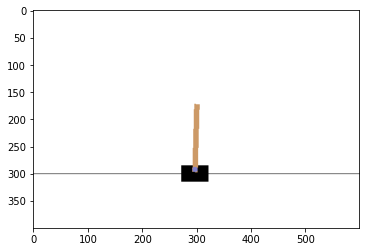

In [20]:
# get render
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

In [21]:
actions, obs, rewards, dones, infos = [], [], [], [], []

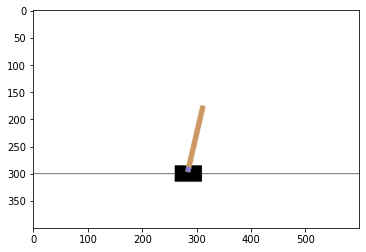

In [22]:
for i in range(50):
  # we sample a random action from the action space
  action = env.action_space.sample()
  # we take a step with that action, and are returned the observation, reward, whether it is done, and information
  ob, reward, done, info = env.step(action)
  # storing these values so we can get a peak at them later
  actions.append(action)
  obs.append(ob)
  rewards.append(reward)
  dones.append(done)
  infos.append(info)
  # getting an rgb picture of the screen (this is only because of colab)
  screen = env.render(mode='rgb_array')
  # displaying image
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break
    
ipythondisplay.clear_output(wait=True)
env.close()

The framerate isn't great, but you get the point - the environment we are simulating is a 2D world with intuitive physics (i.e., gravity) in which the cart--our agent--tries to balance a pole. Why is the cart trying to balance the pole, you may ask? Why did the chicken cross the road?

Let us now look at the different values in the environment. We have actions, observations (states) and rewards.

In [23]:
actions

[1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0]

In [24]:
obs

[array([-0.0214947 ,  0.16289644,  0.02812385, -0.28820596]),
 array([-0.01823677, -0.03261504,  0.02235974,  0.01321262]),
 array([-0.01888907, -0.22805041,  0.02262399,  0.3128656 ]),
 array([-0.02345008, -0.03325794,  0.0288813 ,  0.02740256]),
 array([-0.02411524, -0.22878191,  0.02942935,  0.32905612]),
 array([-0.02869088, -0.42431018,  0.03601047,  0.63087251]),
 array([-0.03717708, -0.2297087 ,  0.04862792,  0.34974433]),
 array([-0.04177125, -0.03531086,  0.05562281,  0.07278323]),
 array([-0.04247747, -0.23118429,  0.05707848,  0.38248367]),
 array([-0.04710116, -0.42706827,  0.06472815,  0.69260309]),
 array([-0.05564252, -0.23290119,  0.07858021,  0.42097919]),
 array([-0.06030055, -0.42904345,  0.08699979,  0.7373635 ]),
 array([-0.06888142, -0.2352239 ,  0.10174706,  0.47327942]),
 array([-0.07358589, -0.43162455,  0.11121265,  0.79621883]),
 array([-0.08221838, -0.23819012,  0.12713703,  0.54048884]),
 array([-0.08698219, -0.04506297,  0.13794681,  0.29041389]),
 array([

In [25]:
rewards

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [26]:
dones

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True]

In [27]:
infos

[{},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {}]

We have an action, which is a direction you move the cart pole, an observation, which is the state at that point (a vector), and a reward, which in our case is all positive. Done is when the game is...err...done (you lose; in this case the pole tips over). This is what the documentation has to say about the variables:

- observation (object): an environment-specific object representing your observation of the environment. For example, pixel data from a camera, joint angles and joint velocities of a robot, or the board state in a board game.
- reward (float): amount of reward achieved by the previous action. The scale varies between environments, but the goal is always to increase your total reward.
- done (boolean): whether it’s time to reset the environment again. Most (but not all) tasks are divided up into well-defined episodes, and done being True indicates the episode has terminated. (For example, perhaps the pole tipped too far, or you lost your last life.)
- info (dict): diagnostic information useful for debugging. It can sometimes be useful for learning (for example, it might contain the raw probabilities behind the environment’s last state change). However, official evaluations of your agent are not allowed to use this for learning.

**This is just an implementation of the classic “agent-environment loop”. Each timestep, the agent chooses an action, and the environment returns an observation and a reward.**

### Spaces

In the examples above, we sampled random actions from the environment’s action space. But how do we characterize those actions? Every environment comes with an action_space and an observation_space. These attributes are of type Space, and they describe the format of valid actions and observations:

In [28]:
print(env.action_space)


Discrete(2)


In [29]:
print(env.observation_space)

Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


The Discrete space allows a fixed range of non-negative numbers, so in this case valid actions are either 0 or 1. The Box space represents an n-dimensional box, and in this case valid observations will be an array of 4 numbers. We can also check the Box’s bounds:

In [30]:
print(env.observation_space.high)


[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


In [31]:
print(env.observation_space.low)


[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


For CartPole-v0 one of the actions moves the cart left, and one moves the cart right. You can go back to the returned actions, and observations to try and figure out which action (1, or 0) pushes it left or right. 

As for the observation space, it is:

**[position of cart, velocity of cart, angle of pole, rotation rate of pole]**

That being said, a good agent won't need to know this information to do the task well. Information on the environments can be found in the [corresponding documentation](https://github.com/openai/gym/wiki/CartPole-v0) for the environment.

This introspection can be helpful to write generic code that works for many different environments. Box and Discrete are the most common Spaces. You can sample from a Space or check that something belongs to it:

In [32]:
from gym import spaces
space = spaces.Discrete(8) # Set with 8 elements {0, 1, 2, ..., 7}
x = space.sample()
assert space.contains(x)
assert space.n == 8



Fortunately, the better your learning algorithm, the less you’ll have to try to interpret these numbers yourself.

Once again, we would recommend peeking at the docs to have a better look at how to manipulate the environment. We will be dealing with similar variables, but our settings can often be very different. 

These numbers will also start to make a lot more sense when we pair them with the agents that will be navigating this space!

# Reinforcement Learning Settings

## Model-free or Model-based

**Model-based** algorithms use definitive knowledge of the environment in which they operate to learn. For example, formal games limit the moves you can make, enabling constraints to be placed on the algorithm to disallow invalid moves and allowing the simulation of valid moves and countermoves into the future. Model-based algorithms do not waste time exploring forbidden paths.

**Model-free** algorithms can apply to any problem, learning strategies through interaction and absorbing environmental rules in process.

Some emerging models violate this distinction, learning models of the environment as they learn optimal strategies (model-free to model-based), or building on the unknown actions of other agents (e.g., players) to counteract their strategies (model-based to model-free).

## Memory

**Online agents** agents improve their policies using only the data they have just observed. They do not store or reuse data from prior experiences.

**Offline agents** can learn from offline datasets or old logs, which most of the best contemporary algorithms agree is useful

Because RL is most useful when agents learn online, many algorithms mix on and offline learning.

## Updating: Off Policy and On Policy

**On-policy** agents learn to predict the reward of being in particular states after choosing actions according to their current policy. This means they typically exploit current knowledge to achieve the best immediate outcomes and can, as a result, learn more quickly.  

**Off-policy** agents learn to predict the reward after choosing any action. This means that they are encouraged to explore more, and perform best in environments with delayed or complex rewards. Contemporary algorithms attempt to balance exploitation of current knowledge with exploration.

## Optimization: Value based, Policy based and Imitation based

**Value-based** algorithms build agents that try as many actions as possible and store the results in a table. In future, they construct an agent to a follow a strategy that yields best results. 

**Policy-based** algorithms maintain a model and tweak its parameters to follow actions producing bests results. If a value-based algorithm remembers to not step off a cliff, a policy-based algorithm remembers to move away from it, yielding a potentially more general, but also more cautious and conservative agent.

**Immitation-based** algorithms mimic the actions of an expert, and can perform well when attempting to incorporate expert experience or guidance.

# Dynamic Programming vs. Monte Carlo Methods

## Code-Driven Introduction to Reinforcement Learning

This is an example from the book [Reinforcement Learning](https://rl-book.com/?utm_source=winder&utm_medium=notebook&utm_campaign=rl), by Dr. Phil Winder. 

In this section you will be investigating the fundamentals of reinforcement learning (RL). The first section summarizes the Markov decision process (MDP) described above, which help you design problems. The second section formulates an RL-driven solution for that MDP.



### Expectations

In the following examples we intentionally use a very simple and visual example. This makes it easier to understand. Although there are [industrial examples](https://rl-book.com/applications/?utm_source=winder&utm_medium=notebook&utm_campaign=rl) that are similar, real-life implementations are likely to be more complex.

## Section 1. The Markov Decision Process

The Markov decision process (MDP) is a mathematical framework that helps you encapsulate the real-world. Despite its simplicity and restrictiveness -- signs of a good interface -- a suprising number of situations can be squeezed into the MDP formalism.

### The MDP Entities

An MDP has two "entities":

- **An agent**: An application that is able to observe state and suggest an action. It also receives feedback to let it know whether the action was good (and how good), or not.
- **An environment**: This is the place where the agent acts within. It accepts an action, which alterts its internal state, and produces a new observation of that state.

In nearly all of the examples that I have seen, these two entities are implemented independently. The agent is often an RL algorithm (although not always) and the environment is either real life or a simulation.

### The MDP Interface

The agent and the environment interact through an interface. You have some control over what goes into that interface and a large amount of effort is typically spent improving the quality of the data that flows through it. You need representations of:

- **State**: This is the observation of the environment. You often get to choose what to "show" to the agent. There is a compromise between simplifying the state to speed up learning and preventing overfitting, but often it pays to include as much as you can.
- **Action**: Your agent must suggest an action. This mutates the environment in some way. So called "options" or "null-actions" allow you to do nothing, if that's what you want to do.
- **Reward**: You use the reward to fine-tune your action choices.

### Creating a "GridWorld" Environment

To make it easy to understand, I'm going to show you how to create a simulation of a simple grid-based "world". Many real-life implementations begin with a simulation of the real world, because it's much easier to iterate and improve your design with a software stub of real-life.

The goal of this environment is to define a "world" in which a "robot" can move. The so-called-world is actually a series of cells inside a 2-dimensional box. The agent can move north, east, south, or west which moves the robot between the cells. The goal of the environment is to reach a goal. There is a reward of -1 for every step, to promote reaching the goal as fast as possible.

#### Imports and Definitions

First let us import a few libraries (to enable autocompletion in later cells) and define a few important definitions. The first is the defacto definition of a "point" object, with x and y coordinates and the second is a direction enumeration. These are use to define the position of the agent in the environment and the direction of movement for an action, respectively. Note that I'm assuming that east moves in a positive x direction and north moves in a positive y direction.

In [33]:
from collections import defaultdict, namedtuple
from enum import Enum
from typing import Tuple, List
import random
from IPython.display import clear_output

Point = namedtuple('Point', ['x', 'y'])
class Direction(Enum):
  NORTH = "⬆"
  EAST = "⮕"
  SOUTH = "⬇"
  WEST = "⬅"

  @classmethod
  def values(self):
    return [v for v in self]

#### The Environment Class

Next create a Python class that represents the environment. The first function in the class is the initialisation function in which we specify the width and height of the environment.

Then define a helper parameter that encodes possible actions and reset the state of the environment with a `reset` function.

In [34]:
class SimpleGridWorld(object):
  def __init__(self, width: int = 5, height: int = 5, debug: bool = False):
    self.width = width
    self.height = height
    self.debug = debug
    self.action_space = [d for d in Direction]
    self.reset()

#### The Reset Function

Many environments have an implicit "reset", whereby the environment's state is moved away from the goal state. In this implementation we reset the environment back to the `(0, 0)` position, but this isn't necessary. Many real-life environments (like the cartpole example above) reset randomly or have no reset.

Here we set the goal, located in the south-eastern corner of the environment.

In [35]:
class SimpleGridWorld(SimpleGridWorld):
  def reset(self):
    self.cur_pos = Point(x=0, y=(self.height - 1))
    self.goal = Point(x=(self.width - 1), y=0)
    # If debug, print state
    if self.debug:
      print(self)
    return self.cur_pos, 0, False

#### Taking a Step

Recall that the MDP interface three key components: state, action, and reward. The environment's step function accepts an action, then produces a new state and reward.

The large amount of code is a consequence of the direction implementation. You can refactor this to use fewer lines of code with clever indexing. However, this level of verbosity helps explain what is going on: every direction moves the current position by one square. You can see the code incrementing or decrementing the x or y coordinates.

The second part of the function tests to see if the agent is at the goal. If it is, then it signals it is at a terminal state.

In [36]:
class SimpleGridWorld(SimpleGridWorld):
  def step(self, action: Direction):
    # Depending on the action, mutate the environment state
    if action == Direction.NORTH:
      self.cur_pos = Point(self.cur_pos.x, self.cur_pos.y + 1)
    elif action == Direction.EAST:
      self.cur_pos = Point(self.cur_pos.x + 1, self.cur_pos.y)
    elif action == Direction.SOUTH:
      self.cur_pos = Point(self.cur_pos.x, self.cur_pos.y - 1)
    elif action == Direction.WEST:
      self.cur_pos = Point(self.cur_pos.x - 1, self.cur_pos.y)
    # Check if out of bounds
    if self.cur_pos.x >= self.width:
      self.cur_pos = Point(self.width - 1, self.cur_pos.y)
    if self.cur_pos.y >= self.height:
      self.cur_pos = Point(self.width, self.cur_pos.y - 1)
    if self.cur_pos.x < 0:
      self.cur_pos = Point(0, self.cur_pos.y)
    if self.cur_pos.y < 0:
      self.cur_pos = Point(self.cur_pos.x, 0)

    # If at goal, terminate
    is_terminal = self.cur_pos == self.goal

    # Constant -1 reward to promote speed-to-goal
    reward = -1

    # If debug, print state
    if self.debug:
      print(self)

    return self.cur_pos, reward, is_terminal

#### Visualisation

It is vitally important that you are able to visualise the behaviour and performance of your agent. The first step in this process is being able to visualise the agent within the environment. The next function does this by printing a textual grid, with an `x` at the agent's location, a `o` at the goal, an `@` if the agent is on top of the goal, and a `_` otherwise.

In [37]:
class SimpleGridWorld(SimpleGridWorld):
  def __repr__(self):
    res = ""
    for y in reversed(range(self.height)):
      for x in range(self.width):
        if self.goal.x == x and self.goal.y == y:
          if self.cur_pos.x == x and self.cur_pos.y == y:
            res += "@"
          else:
            res += "o"
          continue
        if self.cur_pos.x == x and self.cur_pos.y == y:
          res += "x"
        else:
          res += "_"
      res += "\n"
    return res

### Running the Environment

To run the environment you need to instantiate the class, call reset to move the agent back to the start, then perform a series of actions to move the agent. For now we will move it manually, to ensure it is working, visualising the agent at each step. We also print the result of the step (the new state, reward, and terminal flag) for completeness.

In [38]:
s = SimpleGridWorld(debug=True)
print("☝ This shows a simple visualisation of the environment state.\n")
s.step(Direction.SOUTH)
print(s.step(Direction.SOUTH), "⬅ This displays the state and reward from the environment 𝐀𝐅𝐓𝐄𝐑 moving.\n")
s.step(Direction.SOUTH)
s.step(Direction.SOUTH)
s.step(Direction.EAST)
s.step(Direction.EAST)
s.step(Direction.EAST)
s.step(Direction.EAST)

x____
_____
_____
_____
____o

☝ This shows a simple visualisation of the environment state.

_____
x____
_____
_____
____o

_____
_____
x____
_____
____o

(Point(x=0, y=2), -1, False) ⬅ This displays the state and reward from the environment 𝐀𝐅𝐓𝐄𝐑 moving.

_____
_____
_____
x____
____o

_____
_____
_____
_____
x___o

_____
_____
_____
_____
_x__o

_____
_____
_____
_____
__x_o

_____
_____
_____
_____
___xo

_____
_____
_____
_____
____@



(Point(x=4, y=0), -1, True)

#### Key Takeaways

Note a few key lessons:

- The **state** is an observation of the environment, which contains everything outside the agent, including the agent's current position within the environment. In real world applications this could be the time of the day, weather, data from a video camera, literally anything.
- The **reward** specifies the optimal solution to the problem. In real life this might be profit, number of new customers, or attracting click-throughs.
- Every **action** mutates the state of the environment. This may or may not be observable.

## A Reinforcement Learning Solution to the MDP: Implementing the Monte Carlo RL Algorithm

Rather confusingly, RL, like ML, is meant both as a technique and a collection of algorithms. Exactly _when_ an algorithm becomes an RL algorithm is up for debate, but it is generally accepted that there has to be multiple steps (otherwise it would just be a bandit problem, as we illustrate below) and it attempts to quantify the value of being in a particular state.

The _cross-entropy method_ is an algorithm that attempts to stumble across the goal, but once it has then it replicates the same movements again to reach that goal. This is not stricly learning; it is memorising, and so also not an RL algorithm. However, you shouldn't discount it, because it is a very good and simple baseline and can easily complete very sophisticated tasks in a fixed environment if you give it enough time.

Instead, let us introduce a slight variation to this algorithm called the Monte Carlo (MC) method. This lies at the heart of all modern RL algorithms.

MC methods attempt to randomly sample states and judge their value. Once you have sampled the states enough times then you can derive a strategy that follows the path of the next best value.

Let's give it a try.

### Generating trajectories

Monte Carlo techniques operate by sampling the environment. In general, the idea is that if you can sample the environment enough times, you can begin to build a picture of the output, given any input. We can use this idea in RL. If we capture enough _trajectories_, where a trajectory is one full pass through an environment, then we can see which states are advantagous.

To begin, we create a class capable of generating trajectories. Here we pass in the environment, then in the `run` function repeatedly step in the environment using a random action. We store each step in a list and return it to the user.

In [39]:
class MonteCarloGeneration(object):
  def __init__(self, env: object, max_steps: int = 1000, debug: bool = False):
    self.env = env
    self.max_steps = max_steps
    self.debug = debug

  def run(self) -> List:
    buffer = []
    n_steps = 0 # Keep track of the number of steps so I can bail out if it takes too long
    state, _, _ = self.env.reset() # Reset environment back to start
    terminal = False
    while not terminal: # Run until terminal state
      action = random.choice(self.env.action_space) # Random action. Try replacing this with Direction.EAST
      next_state, reward, terminal = self.env.step(action) # Take action in environment
      buffer.append((state, action, reward)) # Store the result
      state = next_state # Ready for the next step
      n_steps += 1
      if n_steps >= self.max_steps:
        if self.debug:
          print("Terminated early due to large number of steps")
        terminal = True # Bail out if we've been working for too long
    return buffer

#### Visualising Trajectories

As before, it's often important to visualise in order to gain an intuition into your problem. A simple first step is to view the agent's movement and trajectory. Here we limit the amount of exploration to save reams of output. Depending on your random seed you will see the agent stumbling around.

In [40]:
env = SimpleGridWorld(debug=True) # Instantiate the environment
generator = MonteCarloGeneration(env=env, max_steps=10, debug=True) # Instantiate the generation
trajectory = generator.run() # Generate a trajectory
print([t[1].value for t in trajectory]) # Print chosen actions
print(f"total reward: {sum([t[2] for t in trajectory])}") # Print final reward

x____
_____
_____
_____
____o

x____
_____
_____
_____
____o

_____
_____
_____
_____
____o

_____
____x
_____
_____
____o

_____
_____
____x
_____
____o

_____
_____
____x
_____
____o

_____
____x
_____
_____
____o

____x
_____
_____
_____
____o

___x_
_____
_____
_____
____o

_____
_____
_____
_____
____o

_____
_____
_____
_____
____o

____x
_____
_____
_____
____o

Terminated early due to large number of steps
['⬆', '⬇', '⬇', '⮕', '⬆', '⬆', '⬅', '⬆', '⬆', '⮕']
total reward: -10


### Quantifying Value

Now consider the _action value function_, a measure of the value of taking a particular action, given all consequences. In other words, you can look at the previous trajectories, find out which of them lead to the highest values and look to use them again. 

To generate an estimate of this value, generate a full trajectory, then look at how far away the agent is from the terminal states at all steps.

This means we need a class to generate a full trajectory, from start to termination. That code is below. First we create a new class that accepts the generator from before; We'll use this later to generate the full trajectory.

Then we create two fields to retain the experience observed by the agent. The first records the expected value at each state. This is the distance to the goal. The second records the number of times the agent has visited that state.

Then we create a helper function to return a key for the dictionary (a.k.a. map) and an action value function to calculate the value of taking each action in each state--the average value over all visits.

In [41]:
class MonteCarloExperiment(object):
  def __init__(self, generator: MonteCarloGeneration):
    self.generator = generator
    self.values = defaultdict(float)
    self.counts = defaultdict(float)

  def _to_key(self, state, action):
    return (state, action)
  
  def action_value(self, state, action) -> float:
    key = self._to_key(state, action)
    if self.counts[key] > 0:
      return self.values[key] / self.counts[key]
    else:
      return 0.0

Next we create a function to store this data after generating a full trajectory. There are several important parts of this function.

The first is that we're using reversed trajectories--starting from the end and working backwards.

The second is that we're averaging expected return over all visits. So this is reporting the average value of an action.

In [42]:
class MonteCarloExperiment(MonteCarloExperiment):
  def run_episode(self) -> None:
    trajectory = self.generator.run() # Generate a trajectory
    episode_reward = 0
    for i, t in enumerate(reversed(trajectory)): # Starting from the terminal state
      state, action, reward = t
      key = self._to_key(state, action)
      episode_reward += reward  # Add the reward to the buffer
      self.values[key] += episode_reward # And add this to the value of this action
      self.counts[key] += 1 # Increment counter

#### Running the Trajectory Generation

Let's test this by setting some expectations. We're reporting the value of taking an action **on average**. So on average, you would expect the value of taking the `EAST` action when next to the terminal state would be -1, because it's right there, it's a single step and therefore a single reward of -1 to get to the terminal state.

Other directions will not be -1, however, because the agent will continue to stumble around.

In [43]:
env = SimpleGridWorld(debug=False) # Instantiate the environment - set the debug to true to see the actual movemen of the agent.
generator = MonteCarloGeneration(env=env, debug=True) # Instantiate the trajectory generator
agent = MonteCarloExperiment(generator=generator)
for i in range(4):
  agent.run_episode()
  print(f"Run {i}: ", [agent.action_value(Point(3,0), d) for d in env.action_space])

Run 0:  [0.0, 0.0, 0.0, 0.0]
Run 1:  [0.0, -1.0, -6.0, -5.0]
Run 2:  [0.0, -1.0, -6.0, -5.0]
Run 3:  [0.0, -1.0, -6.0, -5.0]


So you can see from above that yes, when choosing east from the point to the west of the terminal state the expected return is -1. But notice that the agent (probably) did not observe that result straight away, because it takes time to randomly select it. (Run it a few more times to see what happens, you'll see random changes)

#### Visualising the State Value Function

The state value function is the average expected return for all actions. In general, we see that the value increases the closer we get to the goal. But because of the random movement, especially far from the goal, there will be a lot of noise.

Below I create a helper function to plot this.

In [44]:
def state_value_2d(env, agent):
    res = ""
    for y in reversed(range(env.height)):
      for x in range(env.width):
        if env.goal.x == x and env.goal.y == y:
          res += "   @  "
        else:
          state_value = sum([agent.action_value(Point(x,y), d) for d in env.action_space]) / len(env.action_space)
          res += f'{state_value:6.2f}'
        res += " | "
      res += "\n"
    return res

print(state_value_2d(env, agent))

-58.46 | -39.92 | -44.75 | -100.82 | -73.16 | 
-51.65 | -64.29 | -58.98 | -68.29 | -81.27 | 
-45.40 | -35.67 | -36.25 | -65.62 | -64.43 | 
-28.62 |   0.00 | -41.25 | -43.08 | -46.95 | 
-32.62 |   0.00 | -17.04 |  -3.00 |    @   | 



### Generating Optimal Policies

A _policy_ is a set of rules that an agent should follow. It is a strategy that works for that particular environment. You can now generate thousands of trajectories and track their expected value over time.

With enough averaging, expected values should present a clear picture of what the optimal policy is. See if you can see what it is?

In the code below we instantiate all previous code and the generate 1000 episodes. Then I print out the state value function for every position.

In [45]:
env = SimpleGridWorld() # Instantiate the environment
generator = MonteCarloGeneration(env=env) # Instantiate the trajectory generator
agent = MonteCarloExperiment(generator=generator)
for i in range(1000):
  clear_output(wait=True)
  agent.run_episode()
  print(f"Iteration: {i}")
  # print([agent.action_value(Point(0,4), d) for d in env.action_space]) # Uncomment this line to see the actual values for a particular state
  print(state_value_2d(env, agent), flush=True)
  # time.sleep(0.1) # Uncomment this line if you want to see every episode

Iteration: 999
-81.81 | -77.38 | -82.12 | -80.40 | -78.53 | 
-79.44 | -78.74 | -79.13 | -76.25 | -73.97 | 
-80.49 | -77.53 | -71.89 | -66.01 | -61.94 | 
-81.36 | -76.09 | -66.23 | -57.04 | -44.40 | 
-80.92 | -76.67 | -62.03 | -41.77 |    @   | 



#### Plotting the Optimal Policy

That's right! The optimal policy is to choose the action that picks the highest expected return. In other words, you want to move the agent towards regions of higher reward.

Let me create another helper function to visualise where the maximal actions point...

In [46]:
def argmax(a):
    return max(range(len(a)), key=lambda x: a[x])

def next_best_value_2d(env, agent):
    res = ""
    for y in reversed(range(env.height)):
      for x in range(env.width):
        if env.goal.x == x and env.goal.y == y:
          res += "@"
        else:
          # Find the action that has the highest value
          loc = argmax([agent.action_value(Point(x,y), d) for d in env.action_space])
          res += f'{env.action_space[loc].value}'
        res += " | "
      res += "\n"
    return res

print(next_best_value_2d(env, agent))

⮕ | ⬆ | ⬅ | ⬇ | ⬇ | 
⬅ | ⮕ | ⬇ | ⬇ | ⬇ | 
⮕ | ⮕ | ⬇ | ⬇ | ⬇ | 
⮕ | ⮕ | ⮕ | ⬇ | ⬇ | 
⬇ | ⮕ | ⮕ | ⮕ | @ | 



And there you have it. A policy. The above image spells out what the agent should do in each state. It should move towards regions of higher value. You can see (in general) that the arrows are all pointing towards the goal, as if by magic.

For the arrows that are not, that is a more interesting story. The problem is that the agent is still entirely random at this point. It's stumbling around until it reachest the goal. The agent started in the top left, so on average, it takes a _lot_ of stumbling to find the goal.

Therefore, for the points at the top left, furthest away from the goal, the agent will probably take more random steps before it reachest the goal. In essence, it _doesn't matter which way the agent goes_. It will still take a long time to get there.

Subsequent Monte Carlo algorithms fix this by updating the action value function every episode and using this knowledge to choose the action. So latter iterations of the agent are far more guided and intelligent.

#### One Final Run

To wrap this up, we will run the whole thing one more time. We will plot the state value function and the policy for all iteration steps. Watch how it changes over time. Add a sleep to slow it down to see it changing on each step.

In [47]:
env = SimpleGridWorld() # Instantiate the environment
generator = MonteCarloGeneration(env=env) # Instantiate the trajectory generator
agent = MonteCarloExperiment(generator=generator)
for i in range(1000):
  clear_output(wait=True)
  agent.run_episode()
  print(f"Iteration: {i}")
  print(state_value_2d(env, agent))
  print(next_best_value_2d(env, agent), flush=True)
  # time.sleep(0.1) # Uncomment this line if you want to see the iterations

Iteration: 999
-88.25 | -84.41 | -86.41 | -84.48 | -83.74 | 
-84.42 | -85.28 | -85.27 | -84.15 | -80.21 | 
-82.54 | -83.33 | -79.48 | -72.36 | -67.05 | 
-81.16 | -75.37 | -71.18 | -60.02 | -45.50 | 
-81.41 | -73.56 | -62.91 | -42.73 |    @   | 

⮕ | ⬆ | ⬆ | ⬇ | ⬇ | 
⮕ | ⮕ | ⬇ | ⬇ | ⬇ | 
⬇ | ⬇ | ⮕ | ⬇ | ⬇ | 
⮕ | ⮕ | ⮕ | ⬇ | ⬇ | 
⮕ | ⮕ | ⮕ | ⮕ | @ | 



## Summary and Next Steps

We appreciate that this might be the first time you have encountered Monte Carlo (MC) techniques or RL, so we have intentionally made this first example as simple and free of libraries as possible, to gain experience at the coal-face.

This obviously means that the actual algorithm isn't that intelligent. For example, MC techniques usually go through two phases, policy evaluation, where full trajectories are captured, then policy improvement, where a new policy is derived. This helps stabilise and speed up learning, beacuse they learn on every episode.

Subsequent algorithms then take this idea further and update the policy on every _step_, called _bootstrapping_ which supercharges the RL algorithm to produce _temporal difference_ algorithms (see below).

We encourage you to play around with this code and tinker with the results. Here are some things that you can try:

- Increase or decrease the size of the grid.
- Add other terminating states
- Change the reward to a different value
- Change the reward to produce 0 reward per step, and a positive reward for the terminating state
- Add a terminating state with a massive negative reward, to simulate a cliff
- Add a hole in the middle
- Add a wall
- See if you can add the code to use the policy derived by the agent

There are additional details in the book associated with this tutorial: [Consider buying it](https://rl-book.com/?utm_source=winder&utm_medium=notebook&utm_campaign=rl) if you want to learn more. Good luck!

# Temporal Difference Learning

Temporal difference (TD) learning is a method to improve the current state estimate using estimates of future states. The underlying assumption is that by having some knowledge about the state transition, which is the reward $r$ from transitioning between current and next state, we can achieve a better estimation of the current state return. 
$$
V^{\pi}(s) \leftarrow V^{\pi}(s)+\alpha (r+\gamma V^{\pi}(s') -V^{\pi}(s))
$$
Here, $s$ is the current state and $s'$ is the next state. 





### TD Estimate

We refer to the term $V^{\pi}(s)$ as the *TD Estimate*. This is the estimated value function of current state. 




### TD Target

We refer to the term $r+\gamma V^{\pi}(s')$ as the *TD Target*. This is the target value function that we want to optimize the *TD Estimate* towards. The *TD Target* is calculated based on a value estimate of next state and current reward. By incorporating the additional information $r$, *TD Target* is a more accurate estimate than *TD Estimate*. Drawing an analogy to supervised learning, $r+\gamma V^{\pi}(s')$ is assumed to be the *label*, and  $V^{\pi}(s)$ is the *prediction*. 

TD learning could be applied for both value function $V^{\pi}(s)$ and value action function $Q^{\pi}(s, a)$. In the case for $Q^{\pi}(s, a)$, TD learning unfolds in this way.
$$
Q^{\pi}(s, a) \leftarrow Q^{\pi}(s, a)+\alpha (r+\gamma Q^{\pi}(s', a') -Q^{\pi}(s, a))
$$


# Q-learning

Q-learning is the result of combining TD learning with the optimal Bellman equation. With the philosophy of TD learning, Q-learning builds a better estimate of current state-action pair by using reward information and optimal estimates for the next state-action pair. 
$$
Q^*(s, a) \leftarrow Q^*(s, a)+\alpha (r + \gamma \max_{a'} Q^*(s', a') -Q^*(s, a))
$$
Note that the term $r + \gamma \max_{a'} Q^*(s', a')$ is what we defined as the *TD target* above. Under TD learning, this *TD target* gives a better estimate of the current state-action pair, so we want to update our *TD estimate*, $Q^*(s, a)$, towards it. In other words, we want to minimize the difference between *TD estimate* $Q^*(s, a)$ and *TD target* $r + \gamma \max_{a'} Q^*(s', a')$. 

$$
L(\theta) = (r + \gamma \max_{a'} Q_{\theta}^*(s', a') -Q_{\theta}^*(s, a))^2
$$
As a preview for using deep learning, if we wanted to use a neural network to approximate the optimal action value function $Q^*(s', a')$, $\theta$ would represent the neural network parameters. The goal is to minimize the loss $L(\theta)$ with respect to $\theta$ so that $Q_{\theta}^*(s, a)$ approaches $r + \gamma \max_{a'} Q_{\theta}^*(s', a')$. 


## Q-Learning example

We will draw upon the material from module 12 of the [Deep Learning](https://sites.wustl.edu/jeffheaton/t81-558/) course at  [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx), by  [Jeff Heaton](https://sites.wustl.edu/jeffheaton/).

### Google CoLab Instructions

The following code ensures that Google CoLab is running the correct version of TensorFlow.

In [48]:
try:
    from google.colab import drive
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: using Google CoLab


In [49]:
if COLAB:
  !sudo apt-get install -y xvfb ffmpeg x11-utils
  !pip install -q 'gym==0.10.11'
  !pip install -q 'imageio==2.4.0'
  !pip install -q PILLOW
  !pip install -q 'pyglet==1.3.2'
  !pip install -q pyvirtualdisplay
  !pip install -q tf-agents

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils
0 upgraded, 2 newly installed, 0 to remove and 42 not upgraded.
Need to get 209 kB of archives.
After this operation, 711 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Fetched 209 kB in 0s (508 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No

### Introduction to Q-Learning

Q-Learning is a foundational technique upon which deep reinforcement learning is based.  Before we explore deep reinforcement learning, it is essential to understand Q-Learning.  Several components make up any Q-Learning system.

* **Agent** - The agent is an entity that exists in an environment that takes actions to affect the state of the environment, to receive rewards.
* **Environment** - The environment is the universe that the agent exists in.  The environment is always in a specific state that is changed by the actions of the agent.
* **Actions** - Steps that can be performed by the agent to alter the environment 
* **Step** - A step occurs each time that the agent performs an action and potentially changes the environment state.
* **Episode** - A chain of steps that ultimately culminates in the environment entering a terminal state.
* **Epoch** - A training iteration of the agent that contains some number of episodes.
* **Terminal State** -  A state in which further actions do not make sense.  In many environments, a terminal state occurs when the agent has one, lost, or the environment exceeding the maximum number of steps.

Q-Learning works by building a table that suggests an action for every possible state.  This approach runs into several problems.  First, the environment is usually composed of several continuous numbers, resulting in an infinite number of states. Q-Learning handles continuous states by binning these numeric values into ranges. 

Additionally, Q-Learning primarily deals with discrete actions, such as pressing a joystick up or down.  Out of the box, Q-Learning does not deal with continuous inputs, such as a car's accelerator that can be in a range of positions from released to fully engaged. Researchers have come up with clever tricks to allow Q-Learning to accommodate continuous actions.

As we will see in the next homework, deep neural networks can help to solve the problems of continuous environments and action spaces.  For now, we will apply regular Q-Learning to the Mountain Car problem from OpenAI Gym.

### Introducing the Mountain Car

This section will demonstrate how Q-Learning can create a solution to the mountain car gym environment.  The Mountain car is an environment where a car must climb a mountain.  Because gravity is stronger than the car's engine, even with full throttle, it cannot merely accelerate up the steep slope. The vehicle is situated in a valley and must learn to utilize potential energy by driving up the left hill before the car can make it to the goal at the top of the right hill.

First, it might be helpful to visualize the mountain car environment.  The following code shows this environment.  This code makes use of TF-Agents to perform this render. Usually, we use TF-Agents for the type of deep reinforcement learning that we will see in the next module.  However, for now, TF-Agents is just used to render the mountain car environment.

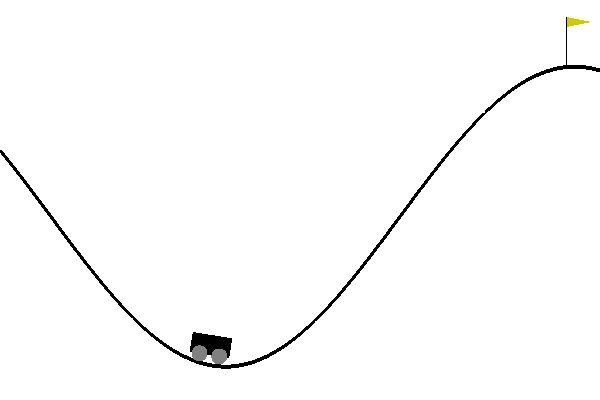

In [50]:
import tf_agents
from tf_agents.environments import suite_gym
import PIL.Image
import pyvirtualdisplay

display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

env_name = 'MountainCar-v0'
env = suite_gym.load(env_name)
env.reset()
PIL.Image.fromarray(env.render())

The mountain car environment provides the following discrete actions:

* 0 - Apply left force
* 1 - Apply no force
* 2 - Apply right force

The mountain car environment is made up of the following continuous values:

* state[0] - Position 
* state[1] - Velocity

The following code shows an agent that applies full throttle to climb the hill.  The cart is not strong enough.  It will need to use potential energy from the mountain behind it.

In [51]:
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [52]:
import gym

if COLAB:
  env = wrap_env(gym.make("MountainCar-v0"))
else:
  env = gym.make("MountainCar-v0")

env.reset()
done = False

i = 0
while not done:
    i += 1
    state, reward, done, _ = env.step(2)
    env.render()
    print(f"Step {i}: State={state}, Reward={reward}")
    
env.close()

Step 1: State=[-0.53666899  0.00110629], Reward=-1.0
Step 2: State=[-0.5344647   0.00220429], Reward=-1.0
Step 3: State=[-0.53117892  0.00328577], Reward=-1.0
Step 4: State=[-0.5268363   0.00434262], Reward=-1.0
Step 5: State=[-0.5214694  0.0053669], Reward=-1.0
Step 6: State=[-0.51511847  0.00635093], Reward=-1.0
Step 7: State=[-0.50783114  0.00728733], Reward=-1.0
Step 8: State=[-0.49966202  0.00816912], Reward=-1.0
Step 9: State=[-0.49067227  0.00898975], Reward=-1.0
Step 10: State=[-0.48092906  0.0097432 ], Reward=-1.0
Step 11: State=[-0.47050501  0.01042405], Reward=-1.0
Step 12: State=[-0.45947748  0.01102753], Reward=-1.0
Step 13: State=[-0.4479279   0.01154958], Reward=-1.0
Step 14: State=[-0.43594098  0.01198691], Reward=-1.0
Step 15: State=[-0.42360395  0.01233703], Reward=-1.0
Step 16: State=[-0.41100569  0.01259827], Reward=-1.0
Step 17: State=[-0.3982359   0.01276979], Reward=-1.0
Step 18: State=[-0.38538433  0.01285157], Reward=-1.0
Step 19: State=[-0.37253991  0.01284441

In [53]:
show_video()

### Programmed Car

Now we will look at a car we hand-programmed.  This car is straightforward; however, it solves the problem. The programmed car always applies force to one direction or another.  It does not break.  Whatever direction the vehicle is currently rolling, the agent uses power in that direction.  Therefore, the car begins to climb a hill, is overpowered, and turns backward.  However, once it starts to roll backward force is immediately applied in this new direction.

The following code implements this preprogrammed car.

In [54]:
import gym

if COLAB:
  env = wrap_env(gym.make("MountainCar-v0"))
else:
  env = gym.make("MountainCar-v0")
  
state = env.reset()
done = False

i = 0
while not done:
    i += 1
    
    if state[1]>0:
        action = 2
    else:
        action = 0
    
    state, reward, done, _ = env.step(action)
    env.render()
    print(f"Step {i}: State={state}, Reward={reward}")
    
env.close()

Step 1: State=[-5.94339877e-01 -4.76912530e-04], Reward=-1.0
Step 2: State=[-0.5952902  -0.00095033], Reward=-1.0
Step 3: State=[-0.59670698 -0.00141678], Reward=-1.0
Step 4: State=[-0.59857983 -0.00187285], Reward=-1.0
Step 5: State=[-0.60089506 -0.00231522], Reward=-1.0
Step 6: State=[-0.60363574 -0.00274068], Reward=-1.0
Step 7: State=[-0.6067819  -0.00314616], Reward=-1.0
Step 8: State=[-0.61031064 -0.00352874], Reward=-1.0
Step 9: State=[-0.61419635 -0.00388571], Reward=-1.0
Step 10: State=[-0.61841091 -0.00421456], Reward=-1.0
Step 11: State=[-0.62292394 -0.00451302], Reward=-1.0
Step 12: State=[-0.62770299 -0.00477906], Reward=-1.0
Step 13: State=[-0.6327139  -0.00501091], Reward=-1.0
Step 14: State=[-0.63792098 -0.00520708], Reward=-1.0
Step 15: State=[-0.64328736 -0.00536638], Reward=-1.0
Step 16: State=[-0.64877524 -0.00548788], Reward=-1.0
Step 17: State=[-0.6543462  -0.00557096], Reward=-1.0
Step 18: State=[-0.65996151 -0.00561531], Reward=-1.0
Step 19: State=[-0.66558239 -

We now visualize the preprogrammed car solving the problem.

In [55]:
show_video()

### Reinforcement Learning

Q-Learning is a system of rewards that the algorithm gives an agent for successfully moving the environment into a state considered successful.  These rewards are the Q-values from which this algorithm takes its name.  The final output from the Q-Learning algorithm is a table of Q-values that indicate the reward value of every action that the agent can take, given every possible environment state. The agent must bin continuous state values into a fixed finite number of columns.

Learning occurs when the algorithm runs the agent and environment through a series of episodes and updates the Q-values based on the rewards received from actions taken; The following figure, repeated from above, provides a high-level overview of this reinforcement or Q-Learning loop.

**Reinforcement/Q Learning**
![Reinforcement Learning](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/reinforcement.png "Reinforcement Learning")

The Q-values can dictate action by selecting the action column with the highest Q-value for the current environment state.  The choice between choosing a random action and a Q-value driven action is governed by the epsilon ($\epsilon$) parameter, which is the probability of random action, as with bandits in our very first algorithm.

Each time through the training loop, the training algorithm updates the Q-values according to the following equation.


$Q^{new}(s_{t},a_{t}) \leftarrow \underbrace{Q(s_{t},a_{t})}_{\text{old value}} + \underbrace{\alpha}_{\text{learning rate}} \cdot  \overbrace{\bigg( \underbrace{\underbrace{r_{t}}_{\text{reward}} + \underbrace{\gamma}_{\text{discount factor}} \cdot \underbrace{\max_{a}Q(s_{t+1}, a)}_{\text{estimate of optimal future value}}}_{\text{new value (temporal difference target)}} - \underbrace{Q(s_{t},a_{t})}_{\text{old value}} \bigg) }^{\text{temporal difference}}$

There are several parameters in this equation:
* alpha ($\alpha$) - The learning rate, how much should the current step cause the Q-values to be updated.
* lambda ($\lambda$) - The discount factor is the percentage of future reward that the algorithm should consider in this update.

This equation modifies several values:

* $Q(s_t,a_t)$ - The Q-table.  For each combination of states, what reward would the agent likely receive for performing each action?
* $s_t$ - The current state.
* $r_t$ - The last reward received.
* $a_t$ - The action that the agent will perform.

The equation works by calculating a delta (temporal difference) that the equation should apply to the old state.  This learning rate ($\alpha$) scales this delta.  A learning rate of 1.0 would fully implement the temporal difference to the Q-values each iteration and would likely be quite chaotic.

There are two parts to the temporal difference: the new and old values.  The new value is subtracted from the old value to provide a delta; the full amount that we would change the Q-value by if the learning rate did not scale this value.  The new value is a summation of the reward received from the last action and the maximum of the Q-values from the resulting state when the client takes this action. It is essential to add the maximum of action Q-values for the new state because it estimates the optimal future values from proceeding with this action. 

### Q-Learning Car

We will now use Q-Learning to produce a car that learns to drive itself.  Look out, Tesla!  We begin by defining two essential functions.


In [56]:
import gym
import numpy as np

# This function converts the floating point state values into 
# discrete values. This is often called binning.  We divide 
# the range that the state values might occupy and assign 
# each region to a bucket.
def calc_discrete_state(state):
    discrete_state = (state - env.observation_space.low)/buckets
    return tuple(discrete_state.astype(np.int))  

# Run one game.  The q_table to use is provided.  We also 
# provide a flag to indicate if the game should be 
# rendered/animated.  Finally, we also provide
# a flag to indicate if the q_table should be updated.
def run_game(q_table, render, should_update):
    done = False
    discrete_state = calc_discrete_state(env.reset())
    success = False
    
    while not done:
        # Exploit or explore
        if np.random.random() > epsilon:
            # Exploit - use q-table to take current best action 
            # (and probably refine)
            action = np.argmax(q_table[discrete_state])
        else:
            # Explore - t
            action = np.random.randint(0, env.action_space.n)
            
        # Run simulation step
        new_state, reward, done, _ = env.step(action)
        
        # Convert continuous state to discrete
        new_state_disc = calc_discrete_state(new_state)

        # Have we reached the goal position (have we won?)?
        if new_state[0] >= env.unwrapped.goal_position:
            success = True
          
        # Update q-table
        if should_update:
            max_future_q = np.max(q_table[new_state_disc])
            current_q = q_table[discrete_state + (action,)]
            new_q = (1 - LEARNING_RATE) * current_q + LEARNING_RATE * \
              (reward + DISCOUNT * max_future_q)
            q_table[discrete_state + (action,)] = new_q

        discrete_state = new_state_disc
        
        if render:
            env.render()
            
    return success


Several hyperparameters are important for Q-Learning. These parameters will likely need adjustment as you apply Q-Learning to other problems.  Because of this, it is crucial to understand the role of each parameter.

* **LEARNING_RATE** The rate at which previous Q-values are updated based on new episodes run during training. 
* **DISCOUNT** The amount of significance to give estimates of future rewards when added to the reward for the current action taken.  A value of 0.95 would indicate a discount of 5% to the future reward estimates. 
* **EPISODES** The number of episodes to train over.  Increase this for more complex problems; however, training time also increases.
* **SHOW_EVERY** How many episodes to allow to elapse before showing an update.
* **DISCRETE_GRID_SIZE** How many buckets to use when converting each of the continuous state variables.  For example, [10, 10] indicates that the algorithm should use ten buckets for the first and second state variables.
* **START_EPSILON_DECAYING** Epsilon is the probability that the agent will select a random action over what the Q-Table suggests. This value determines the starting probability of randomness.
* **END_EPSILON_DECAYING** How many episodes should elapse before epsilon goes to zero and no random actions are permitted. For example, EPISODES//10  means only the first 1/10th of the episodes might have random actions. These two final parameters determine how the algorithm performs simulated annealing.

In [57]:
LEARNING_RATE = 0.1
DISCOUNT = 0.95
EPISODES = 50000
SHOW_EVERY = 1000

DISCRETE_GRID_SIZE = [10, 10]
START_EPSILON_DECAYING = 0.5
END_EPSILON_DECAYING = EPISODES//10

We can now make the environment.  If we are running in Google COLAB then we wrap the environment to be displayed inside the web browser.  Next create the discrete buckets for state and build Q-table.

In [58]:
if COLAB:
  env = wrap_env(gym.make("MountainCar-v0"))
else:
  env = gym.make("MountainCar-v0")

epsilon = 1  
epsilon_change = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)
buckets = (env.observation_space.high - env.observation_space.low) \
    /DISCRETE_GRID_SIZE
q_table = np.random.uniform(low=-3, high=0, size=(DISCRETE_GRID_SIZE \
    + [env.action_space.n]))
success = False

We can now make the environment.  If we are running in Google COLAB then we wrap the environment to be displayed inside the web browser.  Next, create the discrete buckets for state and build Q-table.

In [59]:
episode = 0
success_count = 0

# Loop through the required number of episodes
while episode<EPISODES:
    episode+=1
    done = False

    # Run the game.  If we are local, display render animation at SHOW_EVERY
    # intervals. 
    if episode % SHOW_EVERY == 0:
        print(f"Current episode: {episode}, success: {success_count}" +\
              " ({float(success_count)/SHOW_EVERY})")
        success = run_game(q_table, True, False)
        success_count = 0
    else:
        success = run_game(q_table, False, True)
        
    # Count successes
    if success:
        success_count += 1

    # Move epsilon towards its ending value, if it still needs to move
    if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
        epsilon = max(0, epsilon - epsilon_change)

print(success)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 

Current episode: 1000, success: 0 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 2000, success: 0 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 3000, success: 1 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 4000, success: 46 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 5000, success: 310 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 6000, success: 838 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 7000, success: 838 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 8000, success: 566 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 9000, success: 735 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 10000, success: 426 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 11000, success: 337 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 12000, success: 737 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 13000, success: 470 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 14000, success: 394 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 15000, success: 668 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 16000, success: 824 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 17000, success: 965 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 18000, success: 499 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 19000, success: 928 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 20000, success: 866 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 21000, success: 780 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 22000, success: 971 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 23000, success: 943 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 24000, success: 849 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 25000, success: 641 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 26000, success: 554 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 27000, success: 529 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 28000, success: 605 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 29000, success: 949 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 30000, success: 915 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 31000, success: 801 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 32000, success: 796 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 33000, success: 784 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 34000, success: 810 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 35000, success: 809 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 36000, success: 795 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 37000, success: 785 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 38000, success: 791 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 39000, success: 789 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 40000, success: 799 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 41000, success: 772 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 42000, success: 814 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 43000, success: 794 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 44000, success: 772 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 45000, success: 825 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 46000, success: 568 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 47000, success: 356 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 48000, success: 814 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 49000, success: 909 ({float(success_count)/SHOW_EVERY})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


Current episode: 50000, success: 732 ({float(success_count)/SHOW_EVERY})
True


As you can see, the number of successful episodes generally increases as training progresses.  It is not advisable to stop the first time that we observe 100% success over 1,000 episodes. There is a randomness to most games, so it is not likely that an agent would retain its 100% success rate with a new run.  Once you observe that the agent has gotten 100% for several update intervals, it might be safe to stop training.

### Running and Observing the Agent

Now that the algorithm has trained the agent, we can observe the agent in action. You can use the following code to see the agent in action.

In [60]:
run_game(q_table, True, False)
show_video()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


### Inspecting the Q-Table

We can also display the Q-table.  The following code shows the action that the agent would perform for each environment state.  As the weights of a neural network, this table is not straightforward to interpret.  Some patterns do emerge in that directions do arise, as seen by calculating the means of rows and columns. The actions seem consistent at upper and lower halves of both velocity and position.

In [61]:
# reinstall pandas
!pip install -U pandas

     |████████████████████████████████| 11.3 MB 7.9 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.2
    Uninstalling pandas-1.1.2:
      Successfully uninstalled pandas-1.1.2


In [62]:
import pandas as pd

df = pd.DataFrame(q_table.argmax(axis=2))

df.columns = [f'v-{x}' for x in range(DISCRETE_GRID_SIZE[0])]
df.index = [f'p-{x}' for x in range(DISCRETE_GRID_SIZE[1])]
df

,v-0,v-1,v-2,v-3,v-4,v-5,v-6,v-7,v-8,v-9
p-0,1,0,1,0,0,2,2,1,1,2
p-1,2,0,0,1,2,2,1,2,2,0
p-2,0,2,0,0,1,0,2,2,2,0
p-3,2,0,0,0,2,2,0,2,2,2
p-4,1,0,0,0,0,1,2,2,2,2
p-5,2,0,0,1,2,1,1,2,2,0
p-6,1,2,1,1,1,2,2,1,2,0
p-7,0,0,1,0,0,2,1,1,2,1
p-8,0,2,0,0,0,1,2,2,0,2
p-9,0,0,2,0,1,0,2,2,2,2


In [63]:
df.mean(axis=0)

v-0    0.9
v-1    0.6
v-2    0.5
v-3    0.3
v-4    0.9
v-5    1.3
v-6    1.5
v-7    1.7
v-8    1.7
v-9    1.1
dtype: float64

In [64]:
df.mean(axis=1)

p-0    1.0
p-1    1.2
p-2    0.9
p-3    1.2
p-4    1.0
p-5    1.1
p-6    1.3
p-7    0.8
p-8    0.9
p-9    1.1
dtype: float64

##SARSA - State-Action-Reward-State-Action

### Q-Learning vs. SARSA

Q-Learning and SARSA represent fundamental RL algorithms, both remarkably useful, even today. One of the primary reasons for their popularity is that they are simple, because by default they only work with discrete state and action spaces. Of course it is possible to improve them to work with continuous state/action spaces, but consider discretizing to keep things simple.

SARSA was developed soon after Q-learning to provide a more genernal solution to TD learning. The key difference is that SARSA drops the argmax from the delta, instead calculating the expected return by averaging over all runs in the following online manner.

$Q(s,a) \leftarrow Q(s,a) + \alpha (r+\gamma Q(s', a') - Q(s,a))$

What is the consequence of this difference. SARSA will likely be more conservative and less chaotic because it calculates the *average* expected return rather than the max for a given action.

Here we're going to create a cliffworld example to compare them. This is a gridworld with a desired goal, but a cliff over which an agent can fall if she's not careful (e.g., makes a $\epsilon$ or random action at the cliff's edge).



In [3]:
!pip install simple_rl

import matplotlib
# matplotlib.use("agg", force=True)

In [5]:
import matplotlib
i = 0
while i < 10:
    i += 1
    try:
        matplotlib.use('TkAgg')
        break
    except:
        print(i)

### SARSA Agent

`simple_rl` doesn't have a SARSA agent, so we have to implement one. This is complicated by the abstractions enforced by `simple_rl`, but the key section is in the `update` function. This is choosing and updating an action at the same time. This is different from Q-learning, in that the action chosen is independent of the action updated.

In [6]:

'''
SARSAAgent.py
Implementation of a SARSA agent for simple-rl
'''

# Python imports.
import numpy as np
import math
from collections import defaultdict

# Other imports.
from simple_rl.agents import Agent, QLearningAgent
from simple_rl.tasks import GridWorldMDP


class SARSAAgent(QLearningAgent):
    def __init__(self, actions, goal_reward, name="SARSA",
                 alpha=0.1, gamma=0.99, epsilon=0.1, explore="uniform", anneal=False):
        self.goal_reward = goal_reward
        QLearningAgent.__init__(
            self,
            actions=list(actions),
            name=name,
            alpha=alpha,
            gamma=gamma,
            epsilon=epsilon,
            explore=explore,
            anneal=anneal)

    def policy(self, state):
        return self.get_max_q_action(state)

    def act(self, state, reward, learning=True):
        '''
        This is mostly the same as the base QLearningAgent class. Except that
        the update procedure now generates the action.
        '''
        if learning:
            action = self.update(
                self.prev_state, self.prev_action, reward, state)
        else:
            if self.explore == "softmax":
                # Softmax exploration
                action = self.soft_max_policy(state)
            else:
                # Uniform exploration
                action = self.epsilon_greedy_q_policy(state)

        self.prev_state = state
        self.prev_action = action
        self.step_number += 1

        # Anneal params.
        if learning and self.anneal:
            self._anneal()

        return action

    def update(self, state, action, reward, next_state):
        '''
        Args:
            state (State)
            action (str)
            reward (float)
            next_state (State)
        Summary:
            Updates the internal Q Function according to the Bellman Equation
            using a SARSA update
        '''

        if self.explore == "softmax":
            # Softmax exploration
            next_action = self.soft_max_policy(next_state)
        else:
            # Uniform exploration
            next_action = self.epsilon_greedy_q_policy(next_state)

        # Update the Q Function.
        prev_q_val = self.get_q_value(state, action)
        next_q_val = self.get_q_value(next_state, next_action)
        self.q_func[state][action] = prev_q_val + self.alpha * \
            (reward + self.gamma * next_q_val - prev_q_val)
        return next_action


### Experiment

Now we're ready to run the experiment with the helpers from `simple_rl`. Basically we're training an agent for a maximum of 100 steps, for 500 episodes, averaging over 100 repeats.

Feel free to tinker with the settimgs.

In [7]:
import pandas as pd
import numpy as np

from simple_rl.agents import QLearningAgent, RandomAgent
from simple_rl.tasks import GridWorldMDP
from simple_rl.run_experiments import run_single_agent_on_mdp

np.random.seed(42)
instances = 100
n_episodes = 500
alpha = 0.1
epsilon = 0.1

# Setup MDP, Agents.
mdp = GridWorldMDP(
    width=10, height=4, init_loc=(1, 1), goal_locs=[(10, 1)],
    lava_locs=[(x, 1) for x in range(2, 10)], gamma=1.0, walls=[], slip_prob=0.0, step_cost=1.0, lava_cost=100.0)

print("Q-Learning")
rewards = np.zeros((n_episodes, instances))
for instance in range(instances):
    ql_agent = QLearningAgent(
        mdp.get_actions(),
        epsilon=epsilon,
        alpha=alpha)
    # mdp.visualize_learning(ql_agent, delay=0.0001)
    print("  Instance " + str(instance) + " of " + str(instances) + ".")
    terminal, num_steps, reward = run_single_agent_on_mdp(
        ql_agent, mdp, episodes=n_episodes, steps=100)
    rewards[:, instance] = reward
df = pd.DataFrame(rewards.mean(axis=1))
df.to_json("q_learning_cliff_rewards.json")

print("SARSA")
rewards = np.zeros((n_episodes, instances))
for instance in range(instances):
    sarsa_agent = SARSAAgent(
        mdp.get_actions(),
        goal_reward=0,
        epsilon=epsilon,
        alpha=alpha)
    # mdp.visualize_learning(sarsa_agent, delay=0.0001)
    print("  Instance " + str(instance) + " of " + str(instances) + ".")
    terminal, num_steps, reward = run_single_agent_on_mdp(
        sarsa_agent, mdp, episodes=n_episodes, steps=100)
    rewards[:, instance] = reward
df = pd.DataFrame(rewards.mean(axis=1))
df.to_json("sarsa_cliff_rewards.json")

Q-Learning
  Instance 0 of 100.
  Instance 1 of 100.
  Instance 2 of 100.
  Instance 3 of 100.
  Instance 4 of 100.
  Instance 5 of 100.
  Instance 6 of 100.
  Instance 7 of 100.
  Instance 8 of 100.
  Instance 9 of 100.
  Instance 10 of 100.
  Instance 11 of 100.
  Instance 12 of 100.
  Instance 13 of 100.
  Instance 14 of 100.
  Instance 15 of 100.
  Instance 16 of 100.
  Instance 17 of 100.
  Instance 18 of 100.
  Instance 19 of 100.
  Instance 20 of 100.
  Instance 21 of 100.
  Instance 22 of 100.
  Instance 23 of 100.
  Instance 24 of 100.
  Instance 25 of 100.
  Instance 26 of 100.
  Instance 27 of 100.
  Instance 28 of 100.
  Instance 29 of 100.
  Instance 30 of 100.
  Instance 31 of 100.
  Instance 32 of 100.
  Instance 33 of 100.
  Instance 34 of 100.
  Instance 35 of 100.
  Instance 36 of 100.
  Instance 37 of 100.
  Instance 38 of 100.
  Instance 39 of 100.
  Instance 40 of 100.
  Instance 41 of 100.
  Instance 42 of 100.
  Instance 43 of 100.
  Instance 44 of 100.
  Instanc

### Results

Now you can plot the results for each of the agents.

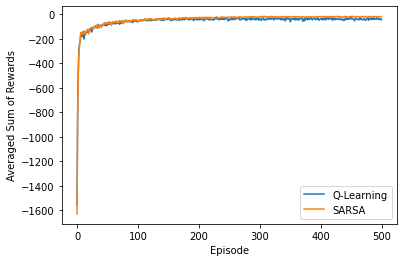

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

data_files = [("Q-Learning", "q_learning_cliff_rewards.json"),
              ("SARSA", "sarsa_cliff_rewards.json")]

fig, ax = plt.subplots()
for j, (name, data_file) in enumerate(data_files):
    df = pd.read_json(data_file)
    x = range(len(df))
    y = df.sort_index().values
    ax.plot(x,
            y,
            linestyle='solid',
            label=name)
ax.set_xlabel('Episode')
ax.set_ylabel('Averaged Sum of Rewards')
ax.legend(loc='lower right')
plt.show()

### Policy Results

If you're not in a notebook, then you can use `simple_rl` to visualize your policy below. You can see that SARSA is less noisy, and ultimately more successful because in cliffworld the SARSA agent prefers the a "safe" path far from the cliff. Why? Because $\epsilon$-greedy action will randomly kick the agent over the cliff. Because SARSA calculates the average expected return (not just the max), it learns to avoid this unfortunate tragedy. 

In [9]:
# mdp.visualize_agent(sarsa_agent)

##Double / Delayed Q-learning

### Delayed Q-learning vs. Double Q-learning vs. Q-Learning

Delayed Q-learning and double Q-learning are two extensions to Q-learning. Delayed Q-learning simply delays any estimate until there is a statistically significant sample of observations. Slowing update with an exponentially weighted moving average is a similar strategy. Double Q-learning includes two Q-tables, in essence two value estimates, to reduce bias. Each update randomly updates one or the other table, such that an outlier will not infect the strategies issuing from both.

This notebook builds upon the Q-learning and SARSA examples from above.



### Experiment

Similar to before, we run the agents on the `CliffWorld` inspired environment. First we setup the the global settings, instantite the environment, then test the three algorithms and save the data. 

If you're not in a notebook you can use the `visualize_policy` function to visualise the policy. `mdp.visualize_policy(ql_agent.policy)` for example.

In [10]:
import pandas as pd
import numpy as np
from simple_rl.agents import DoubleQAgent, DelayedQAgent, QLearningAgent
from simple_rl.tasks import GridWorldMDP
from simple_rl.run_experiments import run_single_agent_on_mdp

np.random.seed(42)
instances = 10
n_episodes = 1000
alpha = 0.1
epsilon = 0.1

# Setup MDP, Agents.
mdp = GridWorldMDP(
    width=10, height=4, init_loc=(1, 1), goal_locs=[(10, 1)],
    lava_locs=[(x, 1) for x in range(2, 10)], gamma=1.0, walls=[], slip_prob=0.0, step_cost=1.0, lava_cost=100.0)

print("Q-Learning")
rewards = np.zeros((n_episodes, instances))
for instance in range(instances):
    ql_agent = QLearningAgent(
        mdp.get_actions(),
        epsilon=epsilon,
        alpha=alpha)
    print("  Instance " + str(instance) + " of " + str(instances) + ".")
    terminal, num_steps, reward = run_single_agent_on_mdp(
        ql_agent, mdp, episodes=n_episodes, steps=100)
    rewards[:, instance] = reward
df = pd.DataFrame(rewards.mean(axis=1))
df.to_json("q_learning_cliff_rewards.json")

print("Double-Q-Learning")
rewards = np.zeros((n_episodes, instances))
for instance in range(instances):
    ql_agent = DoubleQAgent(
        mdp.get_actions(),
        epsilon=epsilon,
        alpha=alpha)
    # mdp.visualize_learning(ql_agent, delay=0.0001)
    print("  Instance " + str(instance) + " of " + str(instances) + ".")
    terminal, num_steps, reward = run_single_agent_on_mdp(
        ql_agent, mdp, episodes=n_episodes, steps=100)
    rewards[:, instance] = reward
df = pd.DataFrame(rewards.mean(axis=1))
df.to_json("double_q_learning_cliff_rewards.json")

print("Delayed-Q-Learning")
rewards = np.zeros((n_episodes, instances))
for instance in range(instances):
    ql_agent = DelayedQAgent(
        mdp.get_actions(),
        epsilon1=alpha)
    # mdp.visualize_learning(ql_agent, delay=0.0001)
    print("  Instance " + str(instance) + " of " + str(instances) + ".")
    terminal, num_steps, reward = run_single_agent_on_mdp(
        ql_agent, mdp, episodes=n_episodes, steps=100)
    rewards[:, instance] = reward
df = pd.DataFrame(rewards.mean(axis=1))
df.to_json("delayed_q_learning_cliff_rewards.json")


Q-Learning
  Instance 0 of 10.
  Instance 1 of 10.
  Instance 2 of 10.
  Instance 3 of 10.
  Instance 4 of 10.
  Instance 5 of 10.
  Instance 6 of 10.
  Instance 7 of 10.
  Instance 8 of 10.
  Instance 9 of 10.
Double-Q-Learning
  Instance 0 of 10.
  Instance 1 of 10.
  Instance 2 of 10.
  Instance 3 of 10.
  Instance 4 of 10.
  Instance 5 of 10.
  Instance 6 of 10.
  Instance 7 of 10.
  Instance 8 of 10.
  Instance 9 of 10.
Delayed-Q-Learning
  Instance 0 of 10.
  Instance 1 of 10.
  Instance 2 of 10.
  Instance 3 of 10.
  Instance 4 of 10.
  Instance 5 of 10.
  Instance 6 of 10.
  Instance 7 of 10.
  Instance 8 of 10.
  Instance 9 of 10.


### Results

Below is the code to visualise the training of the three agents. As usual, there are a maximum of 100 steps, over 200 episodes, averaged over 10 repeats. Feel free to tinker with those settings.

The results show the differences between the three algorithms. In general, double Q-learning tends to be more stable than Q-learning (duh). And delayed Q-learning is more robust against outliers, but can be problematic in environments with larger state/action spaces. You might have to wait for a long time to get the required number of samples for a particular state-action pair, which will delay further exploration.

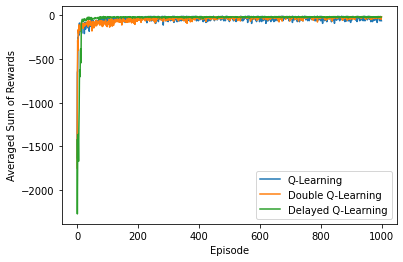

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, AutoMinorLocator
import json
import os
import numpy as np
import pandas as pd

data_files = [("Q-Learning", "q_learning_cliff_rewards.json"),
              ("Double Q-Learning", "double_q_learning_cliff_rewards.json"),
              ("Delayed Q-Learning", "delayed_q_learning_cliff_rewards.json")]
fig, ax = plt.subplots()
for j, (name, data_file) in enumerate(data_files):
    df = pd.read_json(data_file)
    x = range(len(df))
    y = df.sort_index().values
    ax.plot(x,
            y,
            linestyle='solid',
            label=name)
ax.set_xlabel('Episode')
ax.set_ylabel('Averaged Sum of Rewards')
ax.legend(loc='lower right')
plt.show()

### Eligibility Traces SARSA Agent

`simple_rl` doesn't come with an Eligibility Traces SARSA implementation so we must create one first. The code is below. Again, most of the complexity is due to the library abstractions. The most important code is in the `update` function.

In [14]:
import numpy as np
import sys
from collections import defaultdict
from simple_rl.agents import Agent, QLearningAgent


class lambdaSARSAAgent(QLearningAgent):
    def __init__(self, actions, name="lambda SARSA",
                 alpha=0.5, lam=0.5, gamma=1.0, epsilon=0.1, explore="uniform",
                 anneal=False, replacement_method="accumulate"):
        self.lam = lam
        self.eligibility = defaultdict(lambda: defaultdict(lambda: 0))
        self.replacement_method = replacement_method
        QLearningAgent.__init__(
            self,
            actions=list(actions),
            name=name,
            alpha=alpha,
            gamma=gamma,
            epsilon=epsilon,
            explore=explore,
            anneal=anneal)

    def act(self, new_state, reward, learning=True):
        next_action = self.epsilon_greedy_q_policy(new_state)
        if self.prev_state is None:
            self.prev_state = new_state
            self.prev_action = next_action
            return next_action
        self.update(
            self.prev_state,
            self.prev_action,
            reward,
            new_state,
            next_action)
        self.prev_state = new_state
        self.prev_action = next_action
        return next_action

    def update(self, state, action, reward, next_state, next_action):
        td_error = reward + self.gamma * \
            self.q_func[next_state][next_action] - self.q_func[state][action]
        if self.replacement_method == "accumulate":
            self.eligibility[state][action] += 1
        elif self.replacement_method == "replace":
            self.eligibility[state][action] = 1
        for s in self.eligibility.keys():
            for a in self.eligibility[s].keys():
                self.q_func[s][a] += self.alpha * \
                    td_error * self.eligibility[s][a]
                self.eligibility[s][a] *= self.gamma * self.lam

    def end_of_episode(self):
        self.eligibility = defaultdict(lambda: defaultdict(lambda: 0))
        QLearningAgent.end_of_episode(self)


class lambdaWatkinsSARSAAgent(lambdaSARSAAgent):
    def epsilon_greedy_q_policy(self, state):
        # Policy: Epsilon of the time explore, otherwise, greedyQ.
        if np.random.random() > self.epsilon:
            # Exploit.
            action = self.get_max_q_action(state)
        else:
            # Explore
            action = np.random.choice(self.actions)
            # Reset eligibility trace
            self.eligibility = defaultdict(lambda: defaultdict(lambda: 0))
        return action

### Experiment

Similar to before, we run the agents on the `CliffWorld` inspired environment. First we setup the the global settings, instantite the environment, then test the three algorithms and save the data. 

If you're not in a notebook you can use the `visualize_policy` function to visualise the policy. `mdp.visualize_policy(ql_agent.policy)` for example.

In [15]:
import pandas as pd
import numpy as np

from simple_rl.agents import DoubleQAgent, DelayedQAgent
from simple_rl.tasks import GridWorldMDP
from simple_rl.run_experiments import run_single_agent_on_mdp

np.random.seed(42)
instances = 10
n_episodes = 500
alpha = 0.1
epsilon = 0.1

# Setup MDP, Agents.
mdp = GridWorldMDP(
    width=10, height=4, init_loc=(1, 1), goal_locs=[(10, 1)],
    lava_locs=[(x, 1) for x in range(2, 10)], gamma=1.0, walls=[], slip_prob=0.0, step_cost=1.0, lava_cost=100.0)

print("lambda SARSA")
rewards = np.zeros((n_episodes, instances))
for instance in range(instances):
    ql_agent = lambdaSARSAAgent(
        mdp.get_actions(),
        epsilon=epsilon,
        alpha=alpha,
        lam=0.5)
    print("  Instance " + str(instance) + " of " + str(instances) + ".")
    terminal, num_steps, reward = run_single_agent_on_mdp(
        ql_agent, mdp, episodes=n_episodes, steps=100)
    rewards[:, instance] = reward
df = pd.DataFrame(rewards.mean(axis=1))
df.to_json("lambda_sarsa_0.5_cliff_rewards.json")

print("lambda SARSA")
rewards = np.zeros((n_episodes, instances))
for instance in range(instances):
    ql_agent = lambdaSARSAAgent(
        mdp.get_actions(),
        epsilon=epsilon,
        alpha=alpha,
        lam=0.8)
    print("  Instance " + str(instance) + " of " + str(instances) + ".")
    terminal, num_steps, reward = run_single_agent_on_mdp(
        ql_agent, mdp, episodes=n_episodes, steps=100)
    rewards[:, instance] = reward
df = pd.DataFrame(rewards.mean(axis=1))
df.to_json("lambda_sarsa_0.8_cliff_rewards.json")

lambda SARSA
  Instance 0 of 10.
  Instance 1 of 10.
  Instance 2 of 10.
  Instance 3 of 10.
  Instance 4 of 10.
  Instance 5 of 10.
  Instance 6 of 10.
  Instance 7 of 10.
  Instance 8 of 10.
  Instance 9 of 10.
lambda SARSA
  Instance 0 of 10.
  Instance 1 of 10.
  Instance 2 of 10.
  Instance 3 of 10.
  Instance 4 of 10.
  Instance 5 of 10.
  Instance 6 of 10.
  Instance 7 of 10.
  Instance 8 of 10.
  Instance 9 of 10.


### Results

Below is the code to visualise the training of each of the three agents. There are a maximum of 100 steps, over 500 episodes, averaged over 10 repeats. Feel free to tinker with those settings.

The results show the differences between two values for the lambda hyperparameter. Feel free to alter the value to see what happens. Also compare these results to the experiments with SARSA and n-Step agents. Try copying the code from those examples here and plotting the result.

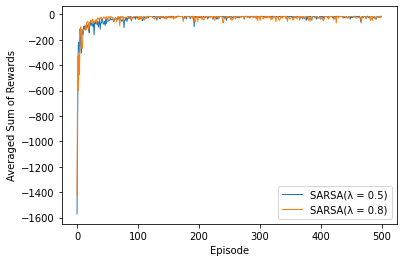

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, AutoMinorLocator
import json
import os
import numpy as np
import pandas as pd

data_files = [("SARSA(λ = 0.5)", "lambda_sarsa_0.5_cliff_rewards.json"),
              ("SARSA(λ = 0.8)", "lambda_sarsa_0.8_cliff_rewards.json"),
              ]
fig, ax = plt.subplots()
for j, (name, data_file) in enumerate(data_files):
    df = pd.read_json(data_file)
    x = range(len(df))
    y = df.sort_index().values
    ax.plot(x,
            y,
            linestyle='solid',
            linewidth=1,
            label=name)
ax.set_xlabel('Episode')
ax.set_ylabel('Averaged Sum of Rewards')
ax.legend(loc='lower right')
plt.show()

# Policy Gradient Methods

## REINFORCE: Monte Carlo Policy Gradient Methods

Policy gradient methods work by first choosing actions directly from a parameterized model, then secondly updating the parameters of the model to nudge the next predictions towards higher expected returns in the following way:

$\theta \leftarrow \theta + \alpha \nabla_{\theta}\mathop{{}\mathbb{E}}_{\pi}[G|s,a]$

where $\theta$ represent the policy model parameters, $\alpha$ the learning rate, $\nabla$ the gradient of the expected return $G$, $\pi$ which proposes an action $a$ condition on a given state $s$ and model $\theta$.

REINFORCE achieves this by collecting a full trajectory then updating the policy weights in Monte Carlo-style:

$\theta \leftarrow \theta + \alpha G \nabla \text{ln} \pi(a|s,\theta)$

where it follows the gradient of the log of the policy $\pi$ which proposes an action $a$ conditional on a given state $s$ and model $\theta$.

To demonstrate this we will implement REINFORCE in `simple_rl` using a logistic policy model.



### Setup and the Environment

For this experiment we will use the now-familiar `cartpole` environment. Then we set the seeds to produce consistent results.

In [17]:
import gym
import random
import numpy as np
from simple_rl.tasks import GymMDP


# Gym MDP
gym_mdp = GymMDP(env_name="CartPole-v1", render=False)
num_feats = gym_mdp.get_num_state_feats()

In [18]:
GLOBAL_SEED = 0
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
gym_mdp.env.seed(GLOBAL_SEED)

[0]

### REINFORCE Agent

The code below defines the REINFORCE agent. The key to this implementation is that we have manually differentiated the logistic function so the gradient can be calculated directly. In a real case you would use an automatic differentiation framework, or use a framework that provides the gradients for you.

Once you have the gradient, then all you need to do is use the policy gradient update rule to nudge the parameters towards areas of higher return.

In [19]:
from simple_rl.agents import PolicyGradientAgent

class LogisticPolicyAgent(PolicyGradientAgent):
    def __init__(self, actions, num_feats):
        self.α = 0.01
        self.γ = 0.99
        self.num_feats = num_feats
        PolicyGradientAgent.__init__(
            self, name="logistic_policy_gradient", actions=actions
        )
        self.reset()

    @staticmethod
    def logistic(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def π(θ, s):
        π = LogisticPolicyAgent.logistic(np.dot(θ.T, s))
        return np.array([π, 1 - π])

    @staticmethod
    def Δ(θ, s):
        π = LogisticPolicyAgent.logistic(np.dot(θ.T, s))
        return np.array([s - s * π, -s * π])

    def act(self, state, reward):
        if self.previous_pair is not None:
            self.episode_history.append(Step(self.previous_pair, reward))
        π = LogisticPolicyAgent.π(self.θ, state)
        action = np.random.choice((0, 1), p=π)
        self.previous_pair = Pair(state.data, action)
        return action

    def reset(self):
        self.θ = np.zeros(self.num_feats)
        self.end_of_episode()
        PolicyGradientAgent.reset(self)

    def end_of_episode(self):
        T = len(getattr(self, "episode_history", []))
        G = 0
        grad_buf = []
        for t in reversed(range(T)):
            G = G * self.γ + self.episode_history[t].reward
            grad = LogisticPolicyAgent.Δ(self.θ, self.episode_history[t].pair.state)[
                self.episode_history[t].pair.action
            ]
            self.θ += self.α * np.power(self.γ, t) * grad * G
            grad_buf.append(np.power(self.γ, t) * grad * G)
        reinforce_gradient_buffer.append(
            [np.mean(np.abs(grad_buf)), np.std(grad_buf)])
        self.episode_history = []
        self.previous_pair = None
        PolicyGradientAgent.end_of_episode(self)


### Training the Agent

Now we're ready to run the experiment and train the agent. You might want to play around with the `instances` parameter, which controls the number of repeats to average over.

In [20]:
from simple_rl.run_experiments import run_agents_on_mdp
from collections import namedtuple

Step = namedtuple("Step", ["pair", "reward"])
Pair = namedtuple("Pair", ["state", "action"])

reinforce_gradient_buffer = []
REINFORCE = LogisticPolicyAgent(gym_mdp.get_actions(), num_feats)
run_agents_on_mdp(
    [REINFORCE],
    gym_mdp,
    instances=2,
    episodes=500,
    steps=1000,
    open_plot=False,
    verbose=False,
    cumulative_plot=False,
)
np.savetxt("gradient_REINFORCE.txt", np.array(reinforce_gradient_buffer))

Running experiment: 
(MDP)
	gym-CartPole-v1
(Agents)
	logistic_policy_gradient,0
(Params)
	instances : 2
	episodes : 500
	steps : 1000
	track_disc_reward : False

logistic_policy_gradient is learning.
  Instance 1 of 2.


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  Instance 2 of 2.


--- TIMES ---
logistic_policy_gradient agent took 30.93 seconds.
-------------

	logistic_policy_gradient: 500.0 (conf_interv: 0.0 )



### Plotting the Results

The following will read from the saved results.

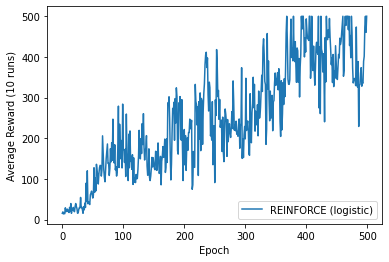

In [21]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, AutoMinorLocator
import matplotlib as mpl
import json
import os
import numpy as np
import pandas as pd
from pathlib import Path
from glob import glob
import subprocess

def plot(experiment_name, data_files, cutoff=None):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    for j, (name, data_file) in enumerate(data_files):
        df = pd.read_csv(data_file, header=None).transpose()
        if cutoff:
            df = df.truncate(after=cutoff)
        x = df.index.values
        y = df.values
        if len(y.shape) > 1:
            y = y.mean(axis=1)
        ax.plot(x,
                y,
                label=name)

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Average Reward (10 runs)')
    ax.legend(loc='lower right')
    plt.show()

data_files = [
    ("REINFORCE (logistic)", "results/gym-CartPole-v1/logistic_policy_gradient.csv"),
]
plot("reinforce_reward_plot", data_files, cutoff=500)

### Discussion

The image above shows the result of plotting the average reward over 500 episodes. The specific curve will depend on your seed and the number of repetitions to average over.

The thing to take away from this experiment is the sheer simplicity of what is going on here. I have defined a very simple model and manually derived the gradient. The environment has 4 continuous features so I need a 4-parameter model. To find an optimal policy, you just need to nudge the gradients towards higher returns. That's it!

This means that policy gradient methods work naturally with continuous state spaces, where value-based methods would struggle, due to required discretisation.



## REINFORCE with Baseline Policy Gradient Algorithm

The various baseline algorithms attempt to stabilise learning by subtracting the average expected return from the action-values, which leads to stable action-values. Contrast this to vanilla policy gradient (as above) or Q-learning algorithms that continuously increment the Q-value, which leads to situations where a minor incremental update to one of the actions causes vast changes in the policy.

In this example we will build upon the previous and also show how to visualise the discounted reward over various states.



### Setup and Previous Agents

In [22]:
import gym
import random
import numpy as np
from simple_rl.tasks import GymMDP


# Gym MDP
gym_mdp = GymMDP(env_name="CartPole-v1", render=False)
num_feats = gym_mdp.get_num_state_feats()

GLOBAL_SEED = 0
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
gym_mdp.env.seed(GLOBAL_SEED)

from simple_rl.agents import PolicyGradientAgent

class LogisticPolicyAgent(PolicyGradientAgent):
    def __init__(self, actions, num_feats):
        self.α = 0.01
        self.γ = 0.99
        self.num_feats = num_feats
        PolicyGradientAgent.__init__(
            self, name="logistic_policy_gradient", actions=actions
        )
        self.reset()

    @staticmethod
    def logistic(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def π(θ, s):
        π = LogisticPolicyAgent.logistic(np.dot(θ.T, s))
        return np.array([π, 1 - π])

    @staticmethod
    def Δ(θ, s):
        π = LogisticPolicyAgent.logistic(np.dot(θ.T, s))
        return np.array([s - s * π, -s * π])

    def act(self, state, reward):
        if self.previous_pair is not None:
            self.episode_history.append(Step(self.previous_pair, reward))
        π = LogisticPolicyAgent.π(self.θ, state)
        action = np.random.choice((0, 1), p=π)
        self.previous_pair = Pair(state.data, action)
        return action

    def reset(self):
        self.θ = np.zeros(self.num_feats)
        self.end_of_episode()
        PolicyGradientAgent.reset(self)

    def end_of_episode(self):
        T = len(getattr(self, "episode_history", []))
        G = 0
        grad_buf = []
        for t in reversed(range(T)):
            G = G * self.γ + self.episode_history[t].reward
            grad = LogisticPolicyAgent.Δ(self.θ, self.episode_history[t].pair.state)[
                self.episode_history[t].pair.action
            ]
            self.θ += self.α * np.power(self.γ, t) * grad * G
            grad_buf.append(np.power(self.γ, t) * grad * G)
        reinforce_gradient_buffer.append(
            [np.mean(np.abs(grad_buf)), np.std(grad_buf)])
        self.episode_history = []
        self.previous_pair = None
        PolicyGradientAgent.end_of_episode(self)


### Reinforce with Baseline Agent

The new agent is basically the same as the standard REINFORCE agent, except for the addition of a weighted moving average to estimate the baseline, which is subtracted from the expected return.

In [23]:

class LogisticPolicyAgentWithBaseline(PolicyGradientAgent):
    def __init__(self, actions, num_feats, α_θ=0.01, prefix=""):
        self.α_θ = α_θ
        self.α_w = 0.1
        self.γ = 0.99
        self.num_feats = num_feats
        PolicyGradientAgent.__init__(
            self, name=prefix + "logistic_policy_gradient_with_baseline", actions=actions
        )
        self.reset()

    def act(self, state, reward):
        if self.previous_pair is not None:
            self.episode_history.append(Step(self.previous_pair, reward))
        π = LogisticPolicyAgent.π(self.θ, state)
        action = np.random.choice((0, 1), p=π)
        self.previous_pair = Pair(state.data, action)
        self.t += 1
        return action

    def reset(self):
        self.θ = np.zeros(self.num_feats)
        self.w = 0
        self.end_of_episode()
        PolicyGradientAgent.reset(self)

    def end_of_episode(self):
        self.t = 0
        T = len(getattr(self, "episode_history", []))
        G = 0
        grad_buf = []
        for t in reversed(range(T)):
            G = G * self.γ + self.episode_history[t].reward
            δ = G - self.w
            global_buffer.append(
                np.concatenate(
                    [self.episode_history[t].pair.state, np.array([G])])
            )
            self.w += self.α_w * δ
            Δπ = LogisticPolicyAgent.Δ(self.θ, self.episode_history[t].pair.state)[
                self.episode_history[t].pair.action
            ]
            self.θ += self.α_θ * np.power(self.γ, t) * δ * Δπ
            grad_buf.append(np.power(self.γ, t) * δ * Δπ)
        baseline_gradient_buffer.append(
            [np.mean(np.abs(grad_buf)), np.std(grad_buf)])
        self.episode_history = []
        self.previous_pair = None
        PolicyGradientAgent.end_of_episode(self)

### Training the Agent

Now we're ready to run the experiment to train the agent. You might want to play around with the `instances` parameter, which controls the number of repeats to average over.

In [24]:
from simple_rl.run_experiments import run_agents_on_mdp
from collections import namedtuple

Step = namedtuple("Step", ["pair", "reward"])
Pair = namedtuple("Pair", ["state", "action"])

reinforce_gradient_buffer = []
REINFORCE = LogisticPolicyAgent(gym_mdp.get_actions(), num_feats)
run_agents_on_mdp(
    [REINFORCE],
    gym_mdp,
    instances=2,
    episodes=500,
    steps=1000,
    open_plot=False,
    verbose=False,
    cumulative_plot=False,
)
np.savetxt("gradient_REINFORCE.txt", np.array(reinforce_gradient_buffer))

global_buffer = []
baseline_gradient_buffer = []
REINFORCE_baseline = LogisticPolicyAgentWithBaseline(
    gym_mdp.get_actions(), num_feats
)
run_agents_on_mdp(
    [REINFORCE_baseline],
    gym_mdp,
    instances=2,
    episodes=500,
    steps=1000,
    open_plot=False,
    verbose=False,
    cumulative_plot=False,
)
np.savetxt("state_reward_REINFORCE_baseline.txt", np.array(global_buffer))
np.savetxt("gradient_REINFORCE_baseline.txt",
            np.array(baseline_gradient_buffer))

Running experiment: 
(MDP)
	gym-CartPole-v1
(Agents)
	logistic_policy_gradient,0
(Params)
	instances : 2
	episodes : 500
	steps : 1000
	track_disc_reward : False

logistic_policy_gradient is learning.
  Instance 1 of 2.


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  Instance 2 of 2.


--- TIMES ---
logistic_policy_gradient agent took 31.47 seconds.
-------------

	logistic_policy_gradient: 407.0 (conf_interv: 13.86 )

Running experiment: 
(MDP)
	gym-CartPole-v1
(Agents)
	logistic_policy_gradient_with_baseline,0
(Params)
	instances : 2
	episodes : 500
	steps : 1000
	track_disc_reward : False

logistic_policy_gradient_with_baseline is learning.
  Instance 1 of 2.


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  Instance 2 of 2.


--- TIMES ---
logistic_policy_gradient_with_baseline agent took 40.59 seconds.
-------------

	logistic_policy_gradient_with_baseline: 390.0 (conf_interv: 152.45 )



### Plotting the Episode Return

The baseline algorithm needs the ability to predict the return for a given state. This means you need a representative model to be able to predict that. I tried a few things, but quickly realised that the data are remarkably complex. The code below takes some trajectories, runs principal component analysis and plots the result. 

Remember that there are four features, so the space is more complex than this. But you can quickly see that the data is strange. It's shaped like a triangle. This is primarily because the next return depends on the previous; it's cumulative. Therefore, we thought we could use a simple online rolling average of previously observed rewards.

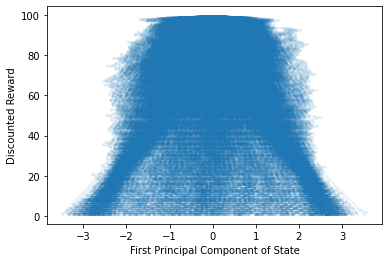

In [25]:
%matplotlib inline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

data = np.loadtxt("state_reward_REINFORCE_baseline.txt")

x = data[:, 0:4]
pca = PCA(n_components=1)
x = pca.fit_transform(x)
y = data[:, 4]

fig, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(x, y, marker='.', alpha=0.1, markeredgewidth=0.0)
ax.set_xlabel('First Principal Component of State')
ax.set_ylabel('Discounted Reward')
plt.show()

### Plotting the Results

The following will read from the saved results.

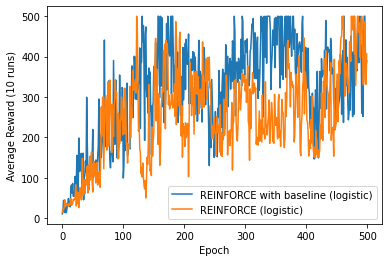

In [26]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, AutoMinorLocator
import matplotlib as mpl
import json
import os
import numpy as np
import pandas as pd
from pathlib import Path
from glob import glob
import subprocess

def plot(experiment_name, data_files, cutoff=None):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    for j, (name, data_file) in enumerate(data_files):
        df = pd.read_csv(data_file, header=None).transpose()
        if cutoff:
            df = df.truncate(after=cutoff)
        x = df.index.values
        y = df.values
        if len(y.shape) > 1:
            y = y.mean(axis=1)
        ax.plot(x,
                y,
                label=name)

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Average Reward (10 runs)')
    ax.legend(loc='lower right')
    plt.show()

data_files = [
    ("REINFORCE with baseline (logistic)", "results/gym-CartPole-v1/logistic_policy_gradient_with_baseline.csv"),
    ("REINFORCE (logistic)", "results/gym-CartPole-v1/logistic_policy_gradient.csv"),
]
plot("reinforce_reward_plot", data_files, cutoff=500)

### Discussion

You can see that the baseline algorithm performs better than the REINFORCE algorithm alone. If you performed more repeats, this would become clearer.

Try this yourself with a single repeat. You should be able to observe the baseline algorithm increasing in performance more consistently than the standard algorithm, which seems to repeatedly drop back to zero. This is because of subtle, but catastrophic updates to the Q-values. Sometimes they nudge the system towards bad policies.



## One-Step Actor-Critic Algorithm

Monte Carlo implementations like those of REINFORCE and baseline do not bootstrap, so they are slow to learn. Temporal difference solutions do bootstrap and can be incorporated into policy gradient algorithms in the same way that n-Step algorithms use it. The addition of n-Step expected returns to the REINFORCE with baseline algorithm yeilds an n-Step actor-critic.

The actor-critic terminology highlights how these algorithms both incporate policy learning (the critic) and the value function (the actor). That terminology obscures how they are implemented as REINFORCE (the policy-learning approach) with a baseline, where the expected return is implemented as n-Step returns. 

We'll implement that below and you'll be suprised how similar the algorithm is. However, this time we're going to use tile coding (described below) to encode the continous state space, to achieve a better baseline estimate.



### Setup and Previous Agents

This is the previous REINFORCE with baseline implementation.

In [27]:
import gym
import random
import numpy as np
from simple_rl.tasks import GymMDP


# Gym MDP
gym_mdp = GymMDP(env_name="CartPole-v1", render=False)
num_feats = gym_mdp.get_num_state_feats()

GLOBAL_SEED = 0
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)
gym_mdp.env.seed(GLOBAL_SEED)

from simple_rl.agents import PolicyGradientAgent

class LogisticPolicyAgent(PolicyGradientAgent):
    def __init__(self, actions, num_feats):
        self.α = 0.01
        self.γ = 0.99
        self.num_feats = num_feats
        PolicyGradientAgent.__init__(
            self, name="logistic_policy_gradient", actions=actions
        )
        self.reset()

    @staticmethod
    def logistic(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def π(θ, s):
        π = LogisticPolicyAgent.logistic(np.dot(θ.T, s))
        return np.array([π, 1 - π])

    @staticmethod
    def Δ(θ, s):
        π = LogisticPolicyAgent.logistic(np.dot(θ.T, s))
        return np.array([s - s * π, -s * π])

    def act(self, state, reward):
        if self.previous_pair is not None:
            self.episode_history.append(Step(self.previous_pair, reward))
        π = LogisticPolicyAgent.π(self.θ, state)
        action = np.random.choice((0, 1), p=π)
        self.previous_pair = Pair(state.data, action)
        return action

    def reset(self):
        self.θ = np.zeros(self.num_feats)
        self.end_of_episode()
        PolicyGradientAgent.reset(self)

    def end_of_episode(self):
        T = len(getattr(self, "episode_history", []))
        G = 0
        grad_buf = []
        for t in reversed(range(T)):
            G = G * self.γ + self.episode_history[t].reward
            grad = LogisticPolicyAgent.Δ(self.θ, self.episode_history[t].pair.state)[
                self.episode_history[t].pair.action
            ]
            self.θ += self.α * np.power(self.γ, t) * grad * G
            grad_buf.append(np.power(self.γ, t) * grad * G)
        reinforce_gradient_buffer.append(
            [np.mean(np.abs(grad_buf)), np.std(grad_buf)])
        self.episode_history = []
        self.previous_pair = None
        PolicyGradientAgent.end_of_episode(self)
        
class LogisticPolicyAgentWithBaseline(PolicyGradientAgent):
    def __init__(self, actions, num_feats, α_θ=0.01, prefix=""):
        self.α_θ = α_θ
        self.α_w = 0.1
        self.γ = 0.99
        self.num_feats = num_feats
        PolicyGradientAgent.__init__(
            self, name=prefix + "logistic_policy_gradient_with_baseline", actions=actions
        )
        self.reset()

    def act(self, state, reward):
        if self.previous_pair is not None:
            self.episode_history.append(Step(self.previous_pair, reward))
        π = LogisticPolicyAgent.π(self.θ, state)
        action = np.random.choice((0, 1), p=π)
        self.previous_pair = Pair(state.data, action)
        self.t += 1
        return action

    def reset(self):
        self.θ = np.zeros(self.num_feats)
        self.w = 0
        self.end_of_episode()
        PolicyGradientAgent.reset(self)

    def end_of_episode(self):
        self.t = 0
        T = len(getattr(self, "episode_history", []))
        G = 0
        grad_buf = []
        for t in reversed(range(T)):
            G = G * self.γ + self.episode_history[t].reward
            δ = G - self.w
            global_buffer.append(
                np.concatenate(
                    [self.episode_history[t].pair.state, np.array([G])])
            )
            self.w += self.α_w * δ
            Δπ = LogisticPolicyAgent.Δ(self.θ, self.episode_history[t].pair.state)[
                self.episode_history[t].pair.action
            ]
            self.θ += self.α_θ * np.power(self.γ, t) * δ * Δπ
            grad_buf.append(np.power(self.γ, t) * δ * Δπ)
        baseline_gradient_buffer.append(
            [np.mean(np.abs(grad_buf)), np.std(grad_buf)])
        self.episode_history = []
        self.previous_pair = None
        PolicyGradientAgent.end_of_episode(self)

### Tile Coding

Tile coding attemps to split the feature space into discrete bins, where you set the bin to 1 if the value is contained within that bin. If you overlap the bin boundaries, you end up with quite an accurate representation of a continuous feature in discrete form.

In [28]:
# Taken from https://github.com/MeepMoop/tilecoding
class TileCoder:
    def __init__(
        self,
        tiles_per_dim,
        value_limits,
        tilings,
        offset=lambda n: 2 * np.arange(n) + 1,
    ):
        tiling_dims = np.array(np.ceil(tiles_per_dim), dtype=np.int) + 1
        self._offsets = (
            offset(len(tiles_per_dim))
            * np.repeat([np.arange(tilings)], len(tiles_per_dim), 0).T
            / float(tilings)
            % 1
        )
        self._limits = np.array(value_limits)
        self._norm_dims = np.array(tiles_per_dim) / (
            self._limits[:, 1] - self._limits[:, 0]
        )
        self._tile_base_ind = np.prod(tiling_dims) * np.arange(tilings)
        self._hash_vec = np.array(
            [np.prod(tiling_dims[0:i]) for i in range(len(tiles_per_dim))]
        )
        self._n_tiles = tilings * np.prod(tiling_dims)

    def __getitem__(self, x):
        off_coords = (
            (x - self._limits[:, 0]) * self._norm_dims + self._offsets
        ).astype(int)
        return self._tile_base_ind + np.dot(off_coords, self._hash_vec)

    @property
    def n_tiles(self):
        return self._n_tiles

### n-Step Actor-Critic Algorithm

The major addition in this implementation is the use of Tile Coding for the baseline estimate. This improves performance over the previous rolling average method. In addition you will also notice the use of the next state to predict the 1-step expected return. There are no other differences.

In [29]:
class OneStepActorCritic(PolicyGradientAgent):
    @staticmethod
    def v(w, S):
        return np.dot(w.T, S)

    @staticmethod
    def Δv(w, S):
        return S

    def augment(self, S):
        S = S[2:]
        a = np.zeros(self.T.n_tiles)
        a[self.T[S]] = 1
        return a

    def __init__(self, actions, num_feats, α_θ=0.01, α_w=0.1, prefix=""):
        self.α_θ = α_θ
        self.α_w = α_w
        self.γ = 0.99
        self.num_feats = num_feats
        # tile coder tiling dimensions, value limits, number of tilings
        tiles_per_dim = [10] * num_feats
        lims = [(-0.72, 0.72), (-5, 5)]
        tilings = 5
        self.T = TileCoder(tiles_per_dim, lims, tilings)
        print(self.T.n_tiles)
        PolicyGradientAgent.__init__(
            self, name=prefix + "one_step_actor_critic", actions=actions
        )
        self.reset()

    def update(self, state, action, reward, next_state, terminal: bool):
        raw_state = state.copy()
        state = self.augment(state)
        next_state = self.augment(next_state)

        v = self.v(self.w, state)
        if terminal:
            δ = reward + self.γ * 0 - v
        else:
            δ = reward + self.γ * self.v(self.w, next_state) - v
        self.w += self.α_w * δ * self.Δv(self.w, state)
        self.θ += (
            self.α_θ * self.I * δ *
            LogisticPolicyAgent.Δ(self.θ, raw_state)[action]
        )
        self.I *= self.γ

    def act(self, state, reward):
        if self.previous_pair is not None:
            self.update(
                self.previous_pair.state,
                self.previous_pair.action,
                reward,
                state.data,
                state.is_terminal(),
            )
        π = LogisticPolicyAgent.π(self.θ, state)
        action = np.random.choice((0, 1), p=π)
        self.previous_pair = Pair(state.data, action)
        self.t += 1
        return action

    def reset(self):
        self.θ = np.zeros(4)
        self.w = np.zeros(self.T.n_tiles)
        self.end_of_episode()
        PolicyGradientAgent.reset(self)

    def end_of_episode(self):
        # print(np.mean(self.w), np.std(self.w), np.min(self.w), np.max(self.w), np.count_nonzero(self.w) / self.T.n_tiles)
        self.I = 1
        self.t = 0
        self.previous_pair = None
        PolicyGradientAgent.end_of_episode(self)

### Training the Agent

Now we're ready to run the experiment to train the agents. We reduce the number of instances to 1 to save time, as we're trying to run 4 separate algorithms. If you increase the number of repetitions this will smooth out the results.

In [30]:
from simple_rl.run_experiments import run_agents_on_mdp
from collections import namedtuple

Step = namedtuple("Step", ["pair", "reward"])
Pair = namedtuple("Pair", ["state", "action"])

global_buffer = []
baseline_gradient_buffer = []
REINFORCE_baseline = LogisticPolicyAgentWithBaseline(
    gym_mdp.get_actions(), num_feats
)
run_agents_on_mdp(
    [REINFORCE_baseline],
    gym_mdp,
    instances=1,
    episodes=500,
    steps=1000,
    open_plot=False,
    verbose=False,
    cumulative_plot=False,
)
np.savetxt("state_reward_REINFORCE_baseline.txt", np.array(global_buffer))
np.savetxt("gradient_REINFORCE_baseline.txt",
            np.array(baseline_gradient_buffer))

TDAC_slow = OneStepActorCritic(
    gym_mdp.get_actions(), 2, α_θ=0.1, α_w=0.01, prefix="slow_weight_")
TDAC_fast = OneStepActorCritic(
    gym_mdp.get_actions(), 2, α_θ=0.1, α_w=0.1, prefix="fast_weight_")
TDAC_super_fast = OneStepActorCritic(
    gym_mdp.get_actions(), 2, α_θ=0.1, α_w=0.5, prefix="super_fast_weight_")
run_agents_on_mdp(
    [TDAC_slow, TDAC_fast, TDAC_super_fast],
    gym_mdp,
    instances=1,
    episodes=500,
    steps=500,
    open_plot=False,
    verbose=False,
    cumulative_plot=False,
)

Running experiment: 
(MDP)
	gym-CartPole-v1
(Agents)
	logistic_policy_gradient_with_baseline,0
(Params)
	instances : 1
	episodes : 500
	steps : 1000
	track_disc_reward : False

logistic_policy_gradient_with_baseline is learning.
  Instance 1 of 1.


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)




--- TIMES ---
logistic_policy_gradient_with_baseline agent took 15.94 seconds.
-------------

	logistic_policy_gradient_with_baseline: 354.0 (conf_interv: 0.0 )

605
605
605
Running experiment: 
(MDP)
	gym-CartPole-v1
(Agents)
	slow_weight_one_step_actor_critic,0
	fast_weight_one_step_actor_critic,1
	super_fast_weight_one_step_actor_critic,2
(Params)
	instances : 1
	episodes : 500
	steps : 500
	track_disc_reward : False

slow_weight_one_step_actor_critic is learning.
  Instance 1 of 1.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.



fast_weight_one_step_actor_critic is learning.
  Instance 1 of 1.

super_fast_weight_one_step_actor_critic is learning.
  Instance 1 of 1.


--- TIMES ---
slow_weight_one_step_actor_critic agent took 29.36 seconds.
fast_weight_one_step_actor_critic agent took 36.83 seconds.
super_fast_weight_one_step_actor_critic agent took 32.13 seconds.
-------------

	slow_weight_one_step_actor_critic: 500.0 (conf_interv: 0.0 )
	fast_weight_one_step_actor_critic: 500.0 (conf_interv: 0.0 )
	super_fast_weight_one_step_actor_critic: 419.0 (conf_interv: 0.0 )



### Plotting the Results

The following will read from the saved results.

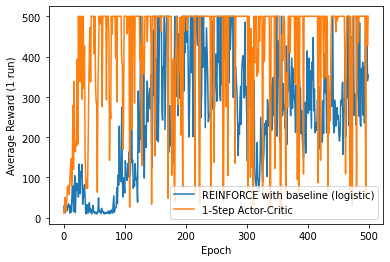

In [31]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot(experiment_name, data_files, cutoff=None):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    for j, (name, data_file) in enumerate(data_files):
        df = pd.read_csv(data_file, header=None).transpose()
        if cutoff:
            df = df.truncate(after=cutoff)
        x = df.index.values
        y = df.values
        if len(y.shape) > 1:
            y = y.mean(axis=1)
        ax.yaxis.major.formatter._useMathText = True
        ax.plot(x,
                y,
                label=name)

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Average Reward (1 run)')
    ax.legend(loc='lower right')
    plt.show()

data_files = [
    ("REINFORCE with baseline (logistic)", "results/gym-CartPole-v1/logistic_policy_gradient_with_baseline.csv"),
    ("1-Step Actor-Critic", "results/gym-CartPole-v1/fast_weight_one_step_actor_critic.csv"),
]
plot("reinforce_reward_plot", data_files, cutoff=500)

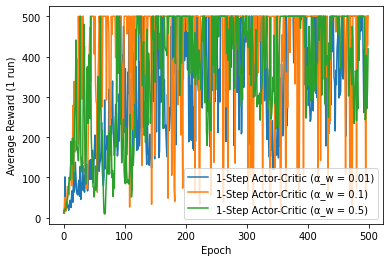

In [32]:
data_files = [
    ("1-Step Actor-Critic (α_w = 0.01)", "results/gym-CartPole-v1/slow_weight_one_step_actor_critic.csv"),
    ("1-Step Actor-Critic (α_w = 0.1)", "results/gym-CartPole-v1/fast_weight_one_step_actor_critic.csv"),
    ("1-Step Actor-Critic (α_w = 0.5)", "results/gym-CartPole-v1/super_fast_weight_one_step_actor_critic.csv"),
]
plot("reinforce_reward_plot", data_files, cutoff=500)

### Discussion

Algorithms that can bootstrap, or in other words, algorithms that can learn from the get-go, learn faster than those that have to wait until an episode is over. n-step algorithms do this and the first plots demonstrate the increase in performance. The plot is noisy because we did not average.

The second image shows the difference between different learning rate parameters. The fastest (0.5) is very unstable. Sometimes it learns, other times it doesn't, because the policy is changing at each step. The slow learning rate (0.01) has a similar performance to the Monte Carlo methods. The learning rate in the middle (0.1) learns fast and is about as stable as the other algorithms. This demonstrates how you must tune your hyperparameters to your specific problem.



# Simple Industrial Example: Automatically Adding Products To A User's Shopping Cart

Covid has sparked demand for online shopping, no more so than online groceries. Yet when we order our groceries, it takes an inordinate amount time to add all items to our basket, even with all the "lists" and "favorites" companies offer.

What about, instead of placing that burden on the customer, accept that burden and design a system to learn what a customer wants and to order the items with zero user interaction. In an ideal scenario the customers will be suprised but happy to receive an unnanounced order, right as they are running out of crucial groceries.

RL is a potential solution to this problem. By allowing an agent to actively send products and learning from refusals, an agent might be able to pick the right items at the right time.

Obviously in the real world you should constrain the problem and potential actions to ensure they are safe and robust, but we won't detail that here.

For this experiment we use a custom environment based upon some real life data from InstaCart. Find out more about that data in the [gym-shopping-cart](https://gitlab.com/winderresearch/rl/gym-shopping-cart) repository.

## Setup and Previous Agents

This experiment uses the eligibility traces implementation of the actor-critic algorithm. Is this better than a simpler 1-step actor-critic implementation? You can test this. We've left the debugging code to allow you to peak inside, if you're interested.

Below that we've also included an "order everything" and random agents as baselines.

In [33]:
from simple_rl.agents import *

class EligibilityActorCritic(PolicyGradientAgent):
    def __init__(self, actions, α_θ=0.1, α_w=0.01, prefix="", λ_w=0.1, λ_θ=0.1):
        self.α_θ = α_θ
        self.α_w = α_w
        self.λ_w = λ_w
        self.λ_θ = λ_θ
        self.γ = 0.99
        self.actions = actions
        PolicyGradientAgent.__init__(
            self, name=prefix + "eligibility_actor_critic", actions=actions
        )
        self.reset()

    @staticmethod
    def v(w, S):
        return np.dot(w.T, S)

    @staticmethod
    def Δv(w, S):
        return S

    @staticmethod
    def logistic(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def π(θ, s):
        return EligibilityActorCritic.logistic(np.dot(θ.T, s))

    @staticmethod
    def Δ(θ, s):
        return s - s * EligibilityActorCritic.logistic(np.dot(θ.T, s))

    @staticmethod
    def π_vec(θ, s):
        return np.array(
            [
                EligibilityActorCritic.logistic(np.dot(θ[:, i].T, s))
                for i in range(θ.shape[1])
            ]
        )

    @staticmethod
    def π_mat(θ, s):
        return EligibilityActorCritic.logistic(np.dot(θ.T, s))

    @staticmethod
    def Δ_vec(θ, s):
        return np.array(
            [
                s - s * EligibilityActorCritic.logistic(np.dot(θ[:, i].T, s))
                for i in range(θ.shape[1])
            ]
        )

    @staticmethod
    def Δ_mat(θ, s):
        return s[:, np.newaxis] - np.outer(
            s, EligibilityActorCritic.logistic(np.dot(θ.T, s))
        )

    def update(self, state, action, reward, next_state, terminal: bool):
        v = self.v(self.w, state)
        if terminal:
            δ = reward + self.γ * 0 - v
        else:
            δ = reward + self.γ * self.v(self.w, next_state) - v
        self.delta_buffer.append(δ)
        self.z_w = self.γ * self.λ_w * self.z_w + self.Δv(self.w, state)
        self.w += self.α_w * δ * self.z_w
        self.z_θ[:, action > 0] = (
            self.γ * self.λ_θ * self.z_θ[:, action > 0]
            + self.I * EligibilityActorCritic.Δ_mat(self.θ, state)[:, action > 0]
        )
        self.z_θ[:, action == 0] = self.γ * self.λ_θ * self.z_θ[:, action == 0]
        self.θ += self.α_θ * δ * self.z_θ
        self.I *= self.γ

    def act(self, state, reward):
        if self.θ is None:
            self.θ = np.zeros((len(state.data), len(self.actions)))
        if self.z_θ is None:
            self.z_θ = np.zeros((len(state.data), len(self.actions)))
        if self.w is None:
            self.w = np.zeros(len(state.data))
        if self.z_w is None:
            self.z_w = np.zeros(len(state.data))
        self.data_buffer.append(state.data)
        # print(state.data.shape, state.data[0])
        # state.data = np.ones(state.data.shape)
        # reward = 1
        if self.previous_pair is not None:
            self.update(
                self.previous_pair.state,
                self.previous_pair.action,
                reward,
                state.data,
                state.is_terminal(),
            )
        π = EligibilityActorCritic.π_mat(self.θ, state)
        # print(π[0])
        action = np.array([np.random.choice(a=(0, 1), p=(1 - p, p)) for p in π])
        self.previous_pair = Pair(state.data, action)
        self.t += 1
        return action

    def reset(self):
        self.θ = None
        self.w = None
        self.delta_buffer = []
        self.data_buffer = []
        self.end_of_episode()
        PolicyGradientAgent.reset(self)

    def end_of_episode(self):
        # print(
        #     np.array2string(
        #         self.θ[:, 0], formatter={"float_kind": lambda x: "%.2f" % x}
        #     )
        # )
        # print(
        #     "{:2d}\t{:+.2f}\t{:+.2f}\t{:+.2f}\t{:+.2f}\t{:+.2f}".format(
        #         self.episode_number,
        #         np.mean(self.θ),
        #         np.sum(np.abs(self.θ)),
        #         np.std(self.θ),
        #         np.min(self.θ),
        #         np.max(self.θ),
        #     )
        # )
        # print(np.mean(self.delta_buffer))
        # print(np.array(self.data_buffer).mean(axis=0).shape)
        # print(np.array(self.data_buffer).mean(axis=0))
        self.data_buffer = []
        self.delta_buffer = []
        self.data_buffer = []
        self.z_θ = None
        self.z_w = None
        self.I = 1
        self.t = 0
        self.previous_pair = None
        PolicyGradientAgent.end_of_episode(self)


class AllOnesAgent(Agent):
    """ Custom random agent for multi-binary actions. """

    def __init__(self, actions, prefix=""):
        Agent.__init__(self, name=prefix + "All ones", actions=actions)

    def act(self, state, reward):
        return np.ones((len(self.actions),))


class MultiBinaryRandomAgent(Agent):
    """ Custom random agent for multi-binary actions. """

    def __init__(self, actions, prefix=""):
        Agent.__init__(self, name=prefix + "Random", actions=actions)

    def act(self, state, reward):
        return np.random.choice([1, 0], size=len(self.actions), p=[0.5, 0.5])

## Helper Functions

Next we need a few helper functions, relating to the chosen policy. We're using a softmax and a hand-derived gradient calculation. You could swap this out for a symbolic or auto-differentiation approach. Note that we're using scipy's `check_grad` method to test that the gradient is correct when doing a finite difference calculation.

In [34]:
from typing import Callable
from collections import namedtuple

import numpy as np
from scipy.optimize import check_grad

def softmax(v):
    exps = np.exp(v)
    sum = np.sum(exps)
    return exps / sum


def softmax_grad(softmax):
    s = softmax.reshape(-1, 1)
    return np.diagflat(s) - np.dot(s, s.T)


def test_differential():
    # Tests that the gradients have been calculated correctly
    s = np.ones((4,))
    θ_test = -1 * np.ones((4, 2))
    test_values = [-1 * np.ones((4, 2)), 0 * np.ones((4, 2)), 1 * np.ones((4, 2))]
    for θ_test in test_values:
        for a in range(θ_test.shape[1]):
            val = check_grad(
                lambda θ: np.log(EligibilityActorCritic.π(θ, s)),
                lambda θ: EligibilityActorCritic.Δ(θ, s),
                θ_test[:, a],
            )
            assert val < 0.0001
    print(
        np.log(EligibilityActorCritic.π(θ_test[:, 0], s)),
        np.log(EligibilityActorCritic.π(θ_test[:, 1], s)),
    )
    print(np.log(EligibilityActorCritic.π_vec(θ_test, s)))
    print(np.log(EligibilityActorCritic.π_mat(θ_test, s)))
    print(
        EligibilityActorCritic.Δ(θ_test[:, 0], s),
        EligibilityActorCritic.Δ(θ_test[:, 1], s),
    )
    print(EligibilityActorCritic.Δ_vec(θ_test, s))
    print(EligibilityActorCritic.Δ_mat(θ_test, s))

Step = namedtuple("Step", ["pair", "reward"])
Pair = namedtuple("Pair", ["state", "action"])

test_differential()

-0.01814992791780973 -0.01814992791780973
[-0.01814993 -0.01814993]
[-0.01814993 -0.01814993]
[0.01798621 0.01798621 0.01798621 0.01798621] [0.01798621 0.01798621 0.01798621 0.01798621]
[[0.01798621 0.01798621 0.01798621 0.01798621]
 [0.01798621 0.01798621 0.01798621 0.01798621]]
[[0.01798621 0.01798621]
 [0.01798621 0.01798621]
 [0.01798621 0.01798621]
 [0.01798621 0.01798621]]


## Running The Experiment: A Single Customer

Now the differential test checks out, we can run the experiment. We're using the eligibility AC algorithm on a single user. The single customer test data comes straight from the library. This path might change if you use the code somewhere else.

In [36]:
!pip install gym_shopping_cart

In [37]:
from pathlib import Path

from simple_rl.tasks import *
from simple_rl.run_experiments import *
from simple_rl.tasks.gym.GymStateClass import GymState
import gym_shopping_cart
from gym_shopping_cart.data.parser import InstacartData

n_instances = 1
n_episodes = 50
max_products = 15

In [42]:
# Single test user
gym_mdp = GymMDP(env_name="SimpleShoppingCart-v0", render=False)
gym_mdp.env.data = InstacartData(
    gz_file=Path(
        "/content/test_data.tar.gz"
    ),
    max_products=max_products,
)
gym_mdp.init_state = GymState(gym_mdp.env.reset())
actions = range(gym_mdp.env.action_space.n)

agent = EligibilityActorCritic(actions, prefix="simple_shopping_single_")
random = MultiBinaryRandomAgent(actions, prefix="simple_shopping_single_")
run_agents_on_mdp(
    [agent, random],
    gym_mdp,
    instances=n_instances,
    episodes=n_episodes,
    steps=1000,
    open_plot=False,
    verbose=False,
    cumulative_plot=False,
)

Overwriting /usr/local/lib/python3.7/dist-packages/gym_shopping_cart/envs/../data/instacart_2017_05_01


Running experiment: 
(MDP)
	gym-SimpleShoppingCart-v0
(Agents)
	simple_shopping_single_eligibility_actor_critic,0
	simple_shopping_single_Random,1
(Params)
	instances : 1
	episodes : 50
	steps : 1000
	track_disc_reward : False

simple_shopping_single_eligibility_actor_critic is learning.
  Instance 1 of 1.

simple_shopping_single_Random is learning.
  Instance 1 of 1.


--- TIMES ---
simple_shopping_single_eligibility_actor_critic agent took 10.22 seconds.
simple_shopping_single_Random agent took 8.01 seconds.
-------------

	simple_shopping_single_eligibility_actor_critic: 30.0 (conf_interv: 0.0 )
	simple_shopping_single_Random: -177.0 (conf_interv: 0.0 )



## Plotting Helper

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot(experiment_name, data_files, cutoff=None, y_lim=None, colors=None, y_label="Average Reward (50 runs)"):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    for j, (name, data_file) in enumerate(data_files):
        df = pd.read_csv(data_file, header=None).transpose()
        if cutoff:
            df = df.truncate(after=cutoff)
        x = df.index.values
        y = df.values
        if len(y.shape) > 1:
            y = y.mean(axis=1)
        ax.plot(
            x,
            y,
            label=name,
        )

    ax.set_xlabel("Episode")
    ax.set_ylabel(y_label)
    if y_lim is not None:
        ax.set_ylim(y_lim)
    ax.legend(frameon=False, loc="center right", ncol=1, handlelength=2)
    plt.show()

## Single Customer Results

Take a look at the results below. After 30 or so interactions with the customer, the agent has learnt what they order and what they like. The number of products being returned is now low enough so that the customer keeps more than they return.

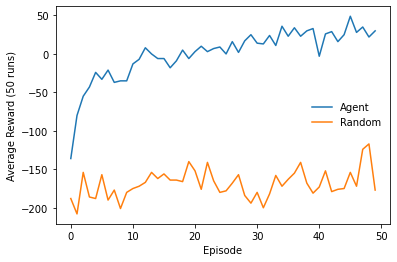

In [44]:
ac_csv = "results/gym-SimpleShoppingCart-v0/simple_shopping_single_eligibility_actor_critic.csv"
random_csv = "results/gym-SimpleShoppingCart-v0/simple_shopping_single_Random.csv"
data_files = [("Agent", ac_csv), ("Random", random_csv)]
plot("simple_shopping_single_user", data_files, cutoff=100)

## Random Customer Results

This is grand, but this was only a single customer. You'd overfit if you continuously retrained and developed against a single customer. Instead, let's try on random customers. For this you need to download more data.

### The Data

The whole data is about 200MB zipped up. There's more information about this data on kaggle: https://www.kaggle.com/c/instacart-market-basket-analysis/

In [45]:
!wget -N https://s3.eu-west-2.amazonaws.com/assets.winderresearch.com/data/instacart_online_grocery_shopping_2017_05_01.tar.gz

--2022-05-04 18:25:39--  https://s3.eu-west-2.amazonaws.com/assets.winderresearch.com/data/instacart_online_grocery_shopping_2017_05_01.tar.gz
Resolving s3.eu-west-2.amazonaws.com (s3.eu-west-2.amazonaws.com)... 52.95.148.12
Connecting to s3.eu-west-2.amazonaws.com (s3.eu-west-2.amazonaws.com)|52.95.148.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 205548478 (196M) [application/x-gzip]
Saving to: ‘instacart_online_grocery_shopping_2017_05_01.tar.gz’

instacart_online_gr 100%[===================>] 196.03M  38.0MB/s    in 5.7s    

2022-05-04 18:25:45 (34.1 MB/s) - ‘instacart_online_grocery_shopping_2017_05_01.tar.gz’ saved [205548478/205548478]



In [46]:
# Random users
gym_mdp = GymMDP(env_name="SimpleShoppingCart-v0", render=False)
gym_mdp.env.data = InstacartData(
    gz_file=Path(
        "instacart_online_grocery_shopping_2017_05_01.tar.gz"
    ),
    max_products=max_products,
)
gym_mdp.init_state = GymState(gym_mdp.env.reset())
actions = range(gym_mdp.env.action_space.n)

agent = EligibilityActorCritic(actions, prefix="simple_shopping_random_")
random = MultiBinaryRandomAgent(actions, prefix="simple_shopping_random_")
run_agents_on_mdp(
    [agent, random],
    gym_mdp,
    instances=n_instances,
    episodes=n_episodes,
    steps=1000,
    open_plot=False,
    verbose=False,
    cumulative_plot=False,
)

Overwriting /usr/local/lib/python3.7/dist-packages/gym_shopping_cart/envs/../data/instacart_2017_05_01
Overwriting instacart_2017_05_01


Running experiment: 
(MDP)
	gym-SimpleShoppingCart-v0
(Agents)
	simple_shopping_random_eligibility_actor_critic,0
	simple_shopping_random_Random,1
(Params)
	instances : 1
	episodes : 50
	steps : 1000
	track_disc_reward : False

simple_shopping_random_eligibility_actor_critic is learning.
  Instance 1 of 1.

simple_shopping_random_Random is learning.
  Instance 1 of 1.


--- TIMES ---
simple_shopping_random_eligibility_actor_critic agent took 16.44 seconds.
simple_shopping_random_Random agent took 14.86 seconds.
-------------

	simple_shopping_random_eligibility_actor_critic: -10.0 (conf_interv: 0.0 )
	simple_shopping_random_Random: -268.0 (conf_interv: 0.0 )



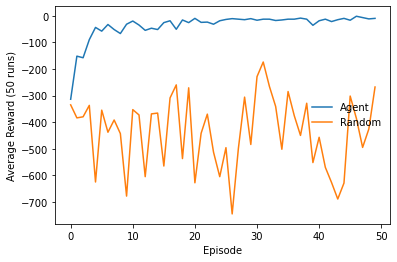

In [47]:
    ac_csv = "results/gym-SimpleShoppingCart-v0/simple_shopping_random_eligibility_actor_critic.csv"
    random_csv = "results/gym-SimpleShoppingCart-v0/simple_shopping_random_Random.csv"
    data_files = [("Agent", ac_csv), ("Random", random_csv)]
    plot("simple_shopping_random_users", data_files, cutoff=100)

You can see that the random results are much more inconsistent now, because each iteration a random user is getting random products.

Whereas the model is still consistently learning. The performance isn't quite as good any more. Around zero, on average. So this means that people are sending back as many products as they are keeping. We should still find this  remarkable. We've had to do very little so far, and already we're providing some level of automated service.

## More Products!

In the previous experiment we limited the number of products to only those that were popular. The more products you include, the longer it will take to learn which products people like. Let's try altering the number of products with the current algorithm.

In [49]:
# Some kind of memory or file leak in here. Not sure what's going on.
# Score vs. num of products
for max_products in [5, 15, 25, 50, 100]:
    gym_mdp = GymMDP(env_name="SimpleShoppingCart-v0", render=False)
    gym_mdp.env.data = InstacartData(
        gz_file=Path(
            "/content/test_data.tar.gz"
        ),
        max_products=max_products,
    )
    gym_mdp.init_state = GymState(gym_mdp.env.reset())
    actions = range(gym_mdp.env.action_space.n)

    agent = EligibilityActorCritic(actions, prefix="simple_shopping_random_products_{}_".format(max_products))
    run_agents_on_mdp(
        [agent],
        gym_mdp,
        instances=n_instances,
        episodes=n_episodes,
        steps=1000,
        open_plot=False,
        verbose=False,
        cumulative_plot=False,
    )

Overwriting /usr/local/lib/python3.7/dist-packages/gym_shopping_cart/envs/../data/instacart_2017_05_01
Overwriting /content/instacart_2017_05_01


Running experiment: 
(MDP)
	gym-SimpleShoppingCart-v0
(Agents)
	simple_shopping_random_products_5_eligibility_actor_critic,0
(Params)
	instances : 1
	episodes : 50
	steps : 1000
	track_disc_reward : False

simple_shopping_random_products_5_eligibility_actor_critic is learning.
  Instance 1 of 1.


Overwriting /usr/local/lib/python3.7/dist-packages/gym_shopping_cart/envs/../data/instacart_2017_05_01




--- TIMES ---
simple_shopping_random_products_5_eligibility_actor_critic agent took 9.38 seconds.
-------------

	simple_shopping_random_products_5_eligibility_actor_critic: 35.0 (conf_interv: 0.0 )



Overwriting /content/instacart_2017_05_01


Running experiment: 
(MDP)
	gym-SimpleShoppingCart-v0
(Agents)
	simple_shopping_random_products_15_eligibility_actor_critic,0
(Params)
	instances : 1
	episodes : 50
	steps : 1000
	track_disc_reward : False

simple_shopping_random_products_15_eligibility_actor_critic is learning.
  Instance 1 of 1.


--- TIMES ---
simple_shopping_random_products_15_eligibility_actor_critic agent took 10.29 seconds.
-------------

	simple_shopping_random_products_15_eligibility_actor_critic: 43.0 (conf_interv: 0.0 )



Overwriting /usr/local/lib/python3.7/dist-packages/gym_shopping_cart/envs/../data/instacart_2017_05_01
Overwriting /content/instacart_2017_05_01


Running experiment: 
(MDP)
	gym-SimpleShoppingCart-v0
(Agents)
	simple_shopping_random_products_25_eligibility_actor_critic,0
(Params)
	instances : 1
	episodes : 50
	steps : 1000
	track_disc_reward : False

simple_shopping_random_products_25_eligibility_actor_critic is learning.
  Instance 1 of 1.


Overwriting /usr/local/lib/python3.7/dist-packages/gym_shopping_cart/envs/../data/instacart_2017_05_01




--- TIMES ---
simple_shopping_random_products_25_eligibility_actor_critic agent took 10.98 seconds.
-------------

	simple_shopping_random_products_25_eligibility_actor_critic: 12.0 (conf_interv: 0.0 )



Overwriting /content/instacart_2017_05_01


Running experiment: 
(MDP)
	gym-SimpleShoppingCart-v0
(Agents)
	simple_shopping_random_products_50_eligibility_actor_critic,0
(Params)
	instances : 1
	episodes : 50
	steps : 1000
	track_disc_reward : False

simple_shopping_random_products_50_eligibility_actor_critic is learning.
  Instance 1 of 1.


Overwriting /usr/local/lib/python3.7/dist-packages/gym_shopping_cart/envs/../data/instacart_2017_05_01




--- TIMES ---
simple_shopping_random_products_50_eligibility_actor_critic agent took 12.88 seconds.
-------------

	simple_shopping_random_products_50_eligibility_actor_critic: -14.0 (conf_interv: 0.0 )



Overwriting /content/instacart_2017_05_01


Running experiment: 
(MDP)
	gym-SimpleShoppingCart-v0
(Agents)
	simple_shopping_random_products_100_eligibility_actor_critic,0
(Params)
	instances : 1
	episodes : 50
	steps : 1000
	track_disc_reward : False

simple_shopping_random_products_100_eligibility_actor_critic is learning.
  Instance 1 of 1.


--- TIMES ---
simple_shopping_random_products_100_eligibility_actor_critic agent took 16.71 seconds.
-------------

	simple_shopping_random_products_100_eligibility_actor_critic: -35.0 (conf_interv: 0.0 )



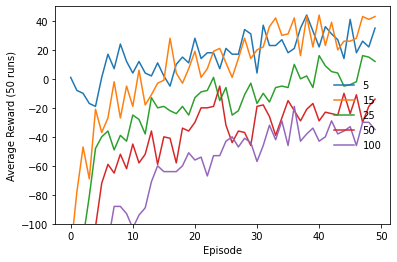

In [50]:
data_files = []
for max_products in [5, 15, 25, 50, 100]:
    csv = "results/gym-SimpleShoppingCart-v0/simple_shopping_random_products_{}_eligibility_actor_critic.csv".format(max_products)
    data_files.append(("{}".format(max_products), csv))
plot("simple_shopping_num_products", data_files, cutoff=50, y_lim=[-100,50], colors=["#000000", "#222222", "#444444", "#666666", "#888888", "#AAAAAA", "#CCCCCC", "#EEEEEE"])

You can see that as the number of products increase, it becomes harder for the algorithm to choose the right products. It's likely that they would reach optimality at some point, but it takes too many interactions. We've run this on the test data to speed it up, but its the same with the random data.

## Transfer Learning

Instead, what we need to do is learn from all customers and apply those learnings to a new one. There's a range of ways we can do this, but one simple solution is to copy weights and retrain. This isn't perfect, because the raw weights are biased towards previous customers. But they may be close enough; a good starting point.

In reality you might seek to be a bit more careful about how you transfer the weights. See the section on scaling in the book for more advanced architectures.

In order to make this work, we need a special "run agents..." method that doesn't reset the environment.

In [51]:
def no_reset_run_agents_on_mdp(agents,
                        mdp,
                        instances=5,
                        episodes=100,
                        steps=200,
                        clear_old_results=True,
                        rew_step_count=1,
                        track_disc_reward=False,
                        open_plot=True,
                        verbose=False,
                        reset_at_terminal=False,
                        cumulative_plot=True,
                        dir_for_plot="results",
                        experiment_name_prefix="",
                        track_success=False,
                        success_reward=None):
    '''
        This is the same as the simple RL version, but I do not reset the agents.
    '''
    if track_success and success_reward is None:
        raise ValueError("(simple_rl): run_agents_on_mdp must set param @success_reward when @track_success=True.")

    # Experiment (for reproducibility, plotting).
    exp_params = {"instances":instances, "episodes":episodes, "steps":steps}
    experiment = Experiment(agents=agents,
                            mdp=mdp,
                            params=exp_params,
                            is_episodic= episodes > 1,
                            clear_old_results=clear_old_results,
                            track_disc_reward=track_disc_reward,
                            count_r_per_n_timestep=rew_step_count,
                            cumulative_plot=cumulative_plot,
                            dir_for_plot=dir_for_plot,
                            experiment_name_prefix=experiment_name_prefix,
                            track_success=track_success,
                            success_reward=success_reward)

    # Record how long each agent spends learning.
    print("Running experiment: \n" + str(experiment))

    # Learn.
    for agent in agents:
        print(str(agent) + " is learning.")

        # For each instance.
        for instance in range(1, instances + 1):
            print("  Instance " + str(instance) + " of " + str(instances) + ".")
            sys.stdout.flush()
            run_single_agent_on_mdp(agent, mdp, episodes, steps, experiment, verbose, track_disc_reward, reset_at_terminal=reset_at_terminal)
            if "fixed" in agent.name:
                break
            # Reset the agent.
            # agent.reset()
            mdp.end_of_instance()

        print()
    experiment.make_plots(open_plot=open_plot)

In [52]:
# Train on Random, test on user
n_instances = 1
n_episodes = 50
gym_mdp = GymMDP(env_name="SimpleShoppingCart-v0", render=False)
gym_mdp.env.data = InstacartData(
    gz_file=Path(
        "instacart_online_grocery_shopping_2017_05_01.tar.gz"
    ),
    max_products=max_products,
)
gym_mdp.init_state = GymState(gym_mdp.env.reset())
actions = range(gym_mdp.env.action_space.n)

agent_transfer = EligibilityActorCritic(actions, prefix="simple_shopping_transfer_random_")
no_reset_run_agents_on_mdp(
    [agent_transfer],
    gym_mdp,
    instances=n_instances,
    episodes=n_episodes,
    steps=1000,
    open_plot=False,
    verbose=False,
    cumulative_plot=False,
    reset_at_terminal=False,
)

n_episodes = 200
gym_mdp.env.data = InstacartData(
    gz_file=Path(
        "instacart_online_grocery_shopping_2017_05_01.tar.gz"
    ),
    max_products=max_products,
)
gym_mdp.init_state = GymState(gym_mdp.env.reset())
actions = range(gym_mdp.env.action_space.n)

agent = EligibilityActorCritic(actions, prefix="simple_shopping_transfer_single_")
agent.θ = agent_transfer.θ
agent.w = agent_transfer.w
no_reset_run_agents_on_mdp(
    [agent],
    gym_mdp,
    instances=n_instances,
    episodes=n_episodes,
    steps=1000,
    open_plot=False,
    verbose=False,
    cumulative_plot=False,
    reset_at_terminal=False,
)

Overwriting /usr/local/lib/python3.7/dist-packages/gym_shopping_cart/envs/../data/instacart_2017_05_01
Overwriting instacart_2017_05_01


Running experiment: 
(MDP)
	gym-SimpleShoppingCart-v0
(Agents)
	simple_shopping_transfer_random_eligibility_actor_critic,0
(Params)
	instances : 1
	episodes : 50
	steps : 1000
	track_disc_reward : False

simple_shopping_transfer_random_eligibility_actor_critic is learning.
  Instance 1 of 1.


Overwriting instacart_2017_05_01



	simple_shopping_transfer_random_eligibility_actor_critic: -41.0 (conf_interv: 0.0 )

Running experiment: 
(MDP)
	gym-SimpleShoppingCart-v0
(Agents)
	simple_shopping_transfer_single_eligibility_actor_critic,0
(Params)
	instances : 1
	episodes : 200
	steps : 1000
	track_disc_reward : False

simple_shopping_transfer_single_eligibility_actor_critic is learning.
  Instance 1 of 1.

	simple_shopping_transfer_single_eligibility_actor_critic: -23.0 (conf_interv: 0.0 )



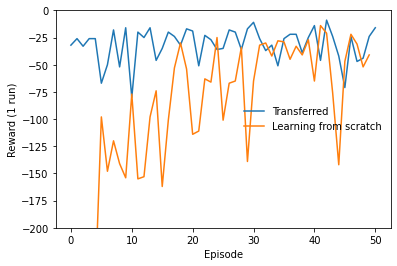

In [53]:
# Transfer learning
random_csv = "results/gym-SimpleShoppingCart-v0/simple_shopping_transfer_random_eligibility_actor_critic.csv"
single_csv = "results/gym-SimpleShoppingCart-v0/simple_shopping_transfer_single_eligibility_actor_critic.csv"
data_files = [("Transferred", single_csv),("Learning from scratch", random_csv),]
plot("simple_shopping_transfer_learning", data_files, cutoff=50, y_lim=[-200, 0], colors=["#000000", "#888888",], y_label="Reward (1 run)")

Now look at those results! The agent is learning which products the customer likes in next to no time at all. The reason for this is that the baseline policy created by the parameters learnt from other customers also works well for new customers. It only takes a few episodes, on average, to converge to an optimal policy.

Yes, there are still caveats. These results are limited to the most popular products, for example. Most people buy milk, so simply re-ordering milk is a quick win. But still, pretty amazing! 

## Future Work

There's a wide range of ideas that you could apply after this. For example, rather than using the raw data, it would be better to build a world model and use that to explore; that would be more representative of the real world. You could try predicting the numbers of products, as well as the type. You could add more products. You could attempt to encode safety rules to prevent stupid suggestions.


# Homework

Reinforcement Learning is somewhat different than our previous examples, and it might take a while for us to identify a setting in which it works well for us. In this homework, we focus on thinking of reinforcement learning scenarios as much as implementing code.

**1)** How would you use reinforcement learning to solve social scientific questions? Be clear in your answer about the environment, the possible states, the actions and its states, reward functions, and trajectories.

In [54]:
rl_world = 'value' #@param {type:"string"}

**2)** Simulate or find data which best matches your social science question and related scenarios. 

**3)** **STRETCH** Use a reinforcement learning algorithm to attempt to model your agent(s) in its environment, and discuss what social scientific and final project-related insights you can gather.

**4)** Use a reinforcement learning algorithm on any dataset not used in this notebook. 